# Une représentation des inégalités scolaires


Ce projet a pour but d'étudier les inégalités scolaires à partir des résultats du baccalauréat et du revenu.
Pour ce faire, nous avons récupéré des données de l'Education nationale sur les taux de réussite aux baccalauréats général, technologique et professionnel en 2021. Par ailleurs, nous utilisons la base de données "Structure et distribution des revenus, inégalité des niveaux de vie en 2019" de l'INSEE. Nous aurons également recours à l'annuaire de l'Education Nationale pour avoir les coordonnées géographiques des lycées. 

Nous cherchons à répondre à la question suivante :
                La réussite au baccalauréat est-elle liée au revenu ?

Le projet est structuré en quatre grandes parties.
La première partie concerne la récupération de toutes les bases de données, leur adaptation à notre projet et leur jointure.
La deuxième partie est dédiée à la visualisation afin de pouvoir d'avoir une première idée de la dynamique des données. Elle regroupe plusieurs statistiques descriptives.
Dans la troisième partie, nous représentons de manière géographique les données que l'on analyse grâce à des cartes interactives.
Dans la dernière partie, nous testons nos hypothèses sur les inégalités scolaires grâce à la modélisation. 
Enfin, nous ajouterons à la fin une annexe rendant compte d'une tentative de modélisation qui n'a pas abouti mais qui nous paraissait intéressante.







## Préliminaire - Installation des packages nécessaires 

In [1]:
!pip install pathlib2
!pip install python-Levenshtein
!pip install openpyxl
!pip install --upgrade xlrd
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install geopandas
!pip install folium


In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import folium
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

## I - Ouverture et manipulation des bases de données

**Pour avoir directement les bases de données finales:** 

In [3]:
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/base_def_SansDOMTOM.xlsx
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/base_definitive.xlsx

### A - La base de données sur les résultats au baccaulauréat par lycée

Cette base de données, disponible sous format excel, réalisée par l'Education Nationale, regroupe de nombreuses informations permettant de quantifier la réussite des lycéens : le taux de réussite au baccalauréat, le taux de mention, la valeur ajoutée des lycées par rapport aux résultats attendus, le taux de passage en première... Elle est composée de 2 fichiers distincts : l'un pour les filières générales et technologiques et l'un pour les filières professionnelles. Nous allons donc traiter ces 2 fichiers séparément, en gardant uniquement les colonnes qui nous intéressent avant de les joindre.

Nous commençons par ouvrir la feuille contenant les données pour les lycées généraux et technologiques. 
Nous supprimons les colonnes qui ne nous seront pas utiles (sur les taux attendus et les effectifs) afin de garder uniquement les taux de réussite.

In [4]:
#Code pour importer directement les données depuis le site
url = "https://www.education.gouv.fr/media/113216/download"
file = requests.get(url, allow_redirects=True)
open('résultats', 'wb').write(file.content)
df = pd.read_excel ("résultats", header = [0,1])

Si les données ne sont plus accessibles, pour la reproductibilité du projet, les données que nous avons utilisées peuvent être importées comme ceci:

In [5]:
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/ival-2021---complet-xlsx-112652.xlsx

In [6]:
fichier_LGT = df.copy()
fichier_LGT = fichier_LGT.drop (["Valeur ajoutée du taux d'accès", "Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus", "Taux de mentions bruts", "Valeur ajoutée de taux de mentions"], axis = 1, level=0)

Les données concernant les bacs technologiques étant divisées par filière, nous avons besoin de regrouper toutes les filières sous une seule colonne technologique. 

Nous commençons par calculer le nombre d'élèves présents au total au baccalauréat technologique. Pour cela, nous devons remplacer les valeurs non existantes par des zéros avant de faire le calcul.

In [7]:
fichier_LGT = fichier_LGT.fillna(0)
fichier_LGT.loc[:,("Nombre d'élèves présents au Bac","Somme Techno")] = fichier_LGT["Nombre d'élèves présents au Bac", 'TOTAL']- fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"]
fichier_LGT["Nombre d'élèves présents au Bac"]


,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Somme Techno
0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54,0.0
1,122.0,28.0,0.0,0.0,0.0,50.0,0.0,0.0,200,78.0
2,98.0,0.0,41.0,0.0,26.0,0.0,0.0,0.0,165,67.0
3,174.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,234,60.0
4,160.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,214,54.0
...,...,...,...,...,...,...,...,...,...,...
2311,246.0,105.0,0.0,0.0,47.0,56.0,0.0,0.0,454,208.0
2312,244.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,360,116.0
2313,325.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,325,0.0
2314,221.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,251,30.0


Ensuite, nous calculons les totaux des taux de réussite bruts pour les filières technologiques. 

Nous faisons la moyenne pondérée par le nombre d’élève des taux de réussite dans toutes les filières techno. Pour des raisons d’arrondis nous n’utilisons pas total - général.

In [8]:
stmg = fichier_LGT["Taux de réussite bruts", "STMG"]*fichier_LGT["Nombre d'élèves présents au Bac", "STMG"]
sti2d = fichier_LGT["Taux de réussite bruts", "STI2D"]*fichier_LGT["Nombre d'élèves présents au Bac", "STI2D"]
std2a = fichier_LGT["Taux de réussite bruts", "STD2A"]*fichier_LGT["Nombre d'élèves présents au Bac", "STD2A"]
stl = fichier_LGT["Taux de réussite bruts", "STL"]*fichier_LGT["Nombre d'élèves présents au Bac", "STL"]
st2s = fichier_LGT["Taux de réussite bruts", "ST2S"]*fichier_LGT["Nombre d'élèves présents au Bac", "ST2S"]
s2tmd = fichier_LGT["Taux de réussite bruts", "S2TMD"]*fichier_LGT["Nombre d'élèves présents au Bac", "S2TMD"]
sthr = fichier_LGT["Taux de réussite bruts", "STHR"]*fichier_LGT["Nombre d'élèves présents au Bac", "STHR"]
taux_tech_brut = (stmg + sti2d + std2a + stl + st2s + s2tmd + sthr)/fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"]


fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Taux de réussite bruts", "Taux brut techno")] = taux_tech_brut #>0.5 pour éviter erreurs d'arrondi de flottants#
fichier_LGT["Taux de réussite bruts"]
#pb avec test à cause des arrondis dans TOTAL (int pas float), résolu avec taux_techno #

,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Taux brut techno
0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98,NaN
1,99.0,96.0,0.0,0.0,0.0,92.0,0.0,0.0,97,93.435897
2,100.0,0.0,100.0,0.0,96.0,0.0,0.0,0.0,99,98.447761
3,97.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,96,93.000000
4,99.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0,99,96.000000
...,...,...,...,...,...,...,...,...,...,...
2311,99.0,99.0,0.0,0.0,96.0,91.0,0.0,0.0,98,96.168269
2312,100.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,100,99.000000
2313,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100,NaN
2314,99.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,99,100.000000


Nous calculons ces mêmes totaux pour les valeurs ajoutées. La difficulté réside dans le format des données dans les colonnes valeur ajoutée.

Nous transformons les ND (« Non Définis ») en NaN et mettons les données dans un format numérique.

In [9]:
liste= ["GNLE", "STMG", "STI2D", "STD2A", "STL", "ST2S", "S2TMD", "STHR", "TOTAL"]
for i in liste:
    fichier_LGT.loc[fichier_LGT["Valeur ajoutée du taux de réussite", i] == "ND", ("Valeur ajoutée du taux de réussite", i)] = np.NaN
    fichier_LGT["Valeur ajoutée du taux de réussite", i] = pd.to_numeric(fichier_LGT["Valeur ajoutée du taux de réussite", i])
fichier_LGT["Valeur ajoutée du taux de réussite"].info()
fichier_LGT["Valeur ajoutée du taux de réussite"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2316 entries, 0 to 2315
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GNLE    2301 non-null   float64
 1   STMG    2295 non-null   float64
 2   STI2D   2309 non-null   float64
 3   STD2A   2314 non-null   float64
 4   STL     2294 non-null   float64
 5   ST2S    2308 non-null   float64
 6   S2TMD   2311 non-null   float64
 7   STHR    2312 non-null   float64
 8   TOTAL   2301 non-null   float64
dtypes: float64(9)
memory usage: 163.0 KB


,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,2.0,5.0,0.0,0.0,0.0,-5.0,0.0,0.0,1.0
2,1.0,0.0,2.0,0.0,-1.0,0.0,0.0,0.0,1.0
3,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2311,0.0,1.0,0.0,0.0,-1.0,-5.0,0.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2314,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0


Nous faisons de même pour les bacs techno

In [10]:
#calcul de la valeur ajoutée du taux de réussite pour les bacs techno, reprend tout pour éviter les problèmes d'arrondis#
stmg = fichier_LGT["Valeur ajoutée du taux de réussite", "STMG"]*fichier_LGT["Nombre d'élèves présents au Bac", "STMG"]
sti2d = fichier_LGT["Valeur ajoutée du taux de réussite", "STI2D"]*fichier_LGT["Nombre d'élèves présents au Bac", "STI2D"]
std2a = fichier_LGT["Valeur ajoutée du taux de réussite", "STD2A"]*fichier_LGT["Nombre d'élèves présents au Bac", "STD2A"]
stl = fichier_LGT["Valeur ajoutée du taux de réussite", "STL"]*fichier_LGT["Nombre d'élèves présents au Bac", "STL"]
st2s = fichier_LGT["Valeur ajoutée du taux de réussite", "ST2S"]*fichier_LGT["Nombre d'élèves présents au Bac", "ST2S"]
s2tmd = fichier_LGT["Valeur ajoutée du taux de réussite", "S2TMD"]*fichier_LGT["Nombre d'élèves présents au Bac", "S2TMD"]
sthr = fichier_LGT["Valeur ajoutée du taux de réussite", "STHR"]*fichier_LGT["Nombre d'élèves présents au Bac", "STHR"]
val_aj_tech = (stmg + sti2d + std2a + stl + st2s + s2tmd + sthr)/fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"]


fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Valeur ajoutée du taux de réussite", "Valeur ajoutée techno")] = val_aj_tech #>0.5 pour éviter les problèmes d'arrondis de flottants#
fichier_LGT["Valeur ajoutée du taux de réussite"]

,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Valeur ajoutée techno
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN
1,2.0,5.0,0.0,0.0,0.0,-5.0,0.0,0.0,1.0,-1.410256
2,1.0,0.0,2.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.835821
3,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-2.000000
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...
2311,0.0,1.0,0.0,0.0,-1.0,-5.0,0.0,0.0,0.0,-1.067308
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2314,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,2.000000


On ré-indexe également la base des lycées généraux et technologiques pour faciliter les manipulations suivantes : nous allons effacer les informations relatives à des filières technologiques spécifiques étant donné qu'on s'intéresse seulement aux bacs technologiques en général.

In [11]:
fichier_LGT.columns = fichier_LGT.columns.map('_'.join).str.strip('_')
fichier_LGT = fichier_LGT.drop(["Nombre d'élèves présents au Bac_STMG","Nombre d'élèves présents au Bac_STI2D", "Nombre d'élèves présents au Bac_STD2A", "Nombre d'élèves présents au Bac_STL", "Nombre d'élèves présents au Bac_ST2S","Nombre d'élèves présents au Bac_S2TMD", "Nombre d'élèves présents au Bac_STHR", "Taux de réussite bruts_STMG",
"Taux de réussite bruts_STI2D","Taux de réussite bruts_STD2A","Taux de réussite bruts_STL","Taux de réussite bruts_ST2S","Taux de réussite bruts_S2TMD","Taux de réussite bruts_STHR", "Valeur ajoutée du taux de réussite_STMG","Valeur ajoutée du taux de réussite_STI2D","Valeur ajoutée du taux de réussite_STD2A", "Valeur ajoutée du taux de réussite_STL", "Valeur ajoutée du taux de réussite_ST2S", "Valeur ajoutée du taux de réussite_S2TMD", "Valeur ajoutée du taux de réussite_STHR"], axis=1)

Nous passons ensuite à la feuille concernant les lycées professionnels. 

Comme pour l'autre feuille, nous supprimons les colonnes qui ne nous sont pas utiles. Puis, nous devons renommer certaines colonnes afin qu'elles aient un nom distinctif quand nous joindrons cette feuille avec les données sur les filières générales et technologiques. 

In [12]:
df2 = pd.read_excel ("résultats", sheet_name = 1, header = [0,1])
fichier_LP = df2.copy()
fichier_LP = fichier_LP.drop (["Valeur ajoutée du taux d'accès", "Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus"], axis = 1, level=0)
fichier_LP.columns = fichier_LP.columns.map('_'.join).str.strip('_')
col_cons = ['Informations établissement_Académie', 'Informations établissement_Département', 'Informations établissement_Etablissement', 'Informations établissement_Ville', 'Informations établissement_UAI', 'Informations établissement_Code commune', 'Informations établissement_Secteur', "Nombre d'élèves présents au Bac_TOTAL", 'Taux de réussite bruts_TOTAL', 'Valeur ajoutée du taux de réussite_TOTAL']
fichier_LP = fichier_LP[col_cons]
fichier_LP = fichier_LP.rename(columns={"Nombre d'élèves présents au Bac_TOTAL": "Nombre d'élèves présents au Bac_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Taux de mentions bruts_TOTAL" : "Taux de mentions bruts_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_Pro"})
fichier_LP

,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,0040003G,04019,PU,15,87,-2
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PROFESSIONNEL BEAU DE ROCHAS,DIGNE LES BAINS,0040007L,04070,PU,104,87,+1
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (PROFESSIONNEL),MANOSQUE,0040533H,04112,PU,28,89,+2
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PROFESSIONNEL LOUIS MARTIN BRET,MANOSQUE,0040011R,04112,PU,146,79,-8
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PAUL ARENE (PROFESSIONNEL),SISTERON,0040023D,04209,PU,37,89,-3
...,...,...,...,...,...,...,...,...,...,...
2008,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,154,82,-3
2009,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,41,98,+1
2010,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,45,98,+3
2011,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,95,96,+2


Nous allons désormais joindre les deux feuilles afin d'avoir sur une même DataFrame les informations concernant les baccalauréats généraux, technologiques et professionnels.

In [13]:
dftotale = pd.concat([fichier_LGT, fichier_LP])
dftotale

,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Nombre d'élèves présents au Bac_TOTAL,Taux de réussite bruts_GNLE,Taux de réussite bruts_TOTAL,Valeur ajoutée du taux de réussite_GNLE,Valeur ajoutée du taux de réussite_TOTAL,Nombre d'élèves présents au Bac_Somme Techno,Taux de réussite bruts_Taux brut techno,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,0040003G,04019,PU,54.0,54.0,98.0,98.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,0040027H,04070,PU,122.0,200.0,99.0,97.0,2.0,1.0,78.0,93.435897,-1.410256,NaN,NaN,NaN
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,0040490L,04070,PU,98.0,165.0,100.0,99.0,1.0,1.0,67.0,98.447761,0.835821,NaN,NaN,NaN
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,0040010P,04112,PU,174.0,234.0,97.0,96.0,-1.0,-1.0,60.0,93.000000,-2.000000,NaN,NaN,NaN
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (GENERAL ET TECHNO.),MANOSQUE,0040533H,04112,PU,160.0,214.0,99.0,99.0,0.0,1.0,54.0,96.000000,-1.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.0,82.0,-3
2009,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,98.0,+1
2010,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,98.0,+3
2011,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,96.0,+2


### B- La base de données sur la distribution des revenus entre les communes 

Nous allons maintenant procéder au nettoyage de la base de données regroupant diverses informations sur les communes françaises : nombre d'habitants, de foyers fiscaux, diverses informations sur la répartition des revenus etc...
L'objectif sera de la fusionner avec notre base de données des lycées afin d'associer à chaque lycée le revenu médian de la ville dans laquelle il se situe (et éventuellement d'autres informations à caractère socio-économique). Nous avons conscience que cela peut être une limite de notre projet car tous les lycéens d'un lycée n'habitent pas dans la même commune et les grandes villes ont plusieurs lycées. Pour autant, nous n'avons pas accès aux cartes scolaires pour les lycées et cela ne nous empêche pas d'étudier les inégalités entre les départements et les académies. 

Dans un premier temps, nous allons retirer un certain nombre de colonnes qui ne nous intéressent pas. Nous souhaitons simplement garder les informations qui pourront nous permettre de fusionner les bases de données (les codes et libellés), les informations sur la taille des populations et le revenu médian de la commune que nous choisissons comme mesure de la situation économique des habitants. Le reste ne nous sera pas utile.

In [14]:
#Pour aller chercher directement le fichier des communes sur le site
from zipfile import ZipFile
url = "https://www.insee.fr/fr/statistiques/fichier/6036907/indic-struct-distrib-revenu-2019-COMMUNES.zip"
file = requests.get(url, allow_redirects=True)
open('communes.zip', 'wb').write(file.content)
with ZipFile('communes.zip', 'r') as com:
    com.extractall(members = ['FILO2019_DEC_COM.xlsx'])

Si les données ne sont plus accessibles, pour la reproductibilité du projet, les données que nous avons utilisées peuvent être importées comme ceci:

In [15]:
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/FILO2019_DEC_COM.xlsx

In [16]:
df_communes = pd.read_excel("FILO2019_DEC_COM.xlsx", sheet_name = 1, header=[4,5])
df_com = df_communes.copy()
df_com = df_com.drop(['PMIMP19', 'Q119', 'Q319','Q3_Q1','D119', 'D219', 'D319', 'D419', 'D619', 'D719', 'D819', 'D919', 'RD', 'S80S2019', 'PACT19', 'PTSA19', 'PCHO19', 'PBEN19', 'PPEN19', 'PAUT19'], axis = 1, level = 1 )
df_com

,Code géographique,Libellé géographique,Nbre de ménages fiscaux,Nbre de personnes dans les ménages fiscaux,Nbre d'unités de consommation dans les ménages fiscaux,Médiane (€),Indice de Gini
,CODGEO,LIBGEO,NBMEN19,NBPERS19,NBUC19,Q219,GI19
0,01001,L'Abergement-Clémenciat,322,819,542.7,24210,NaN
1,01002,L'Abergement-de-Varey,114,267,179.5,23380,NaN
2,01004,Ambérieu-en-Bugey,6713,15041,10298.9,19690,0.384
3,01005,Ambérieux-en-Dombes,720,1823,1204.3,24100,NaN
4,01007,Ambronay,1163,2857,1892.3,23340,0.254
...,...,...,...,...,...,...,...
31359,97420,Sainte-Suzanne,8346,23842,15051.4,14100,0.482
31360,97421,Salazie,2469,6936,4407.0,7740,0.537
31361,97422,Le Tampon,30083,78013,50752.2,12370,0.504


Etant donné que les villes de Paris, Lyon et Marseille apparaissent deux fois (en entier et par arrondissement), on supprime de la base de données les villes globalisées afin d'éviter des répétitions de données. Nous conservons leurs informations seulement par arrondissement étant donné que dans la base des lycées, les établissements sont situés par arrondissements.

In [17]:
supp = []
supp.append(df_com[df_com['Libellé géographique', 'LIBGEO']=='Paris'].index.tolist()[0]) 
supp.append(df_com[df_com['Libellé géographique', 'LIBGEO']=='Lyon'].index.tolist()[0]) 
supp.append(df_com[df_com['Libellé géographique', 'LIBGEO']=='Marseille'].index.tolist()[0]) 
df_com = df_com.drop(supp, axis=0)
df_com.reset_index() #Pour éviter tout problème d'index
df_com

,Code géographique,Libellé géographique,Nbre de ménages fiscaux,Nbre de personnes dans les ménages fiscaux,Nbre d'unités de consommation dans les ménages fiscaux,Médiane (€),Indice de Gini
,CODGEO,LIBGEO,NBMEN19,NBPERS19,NBUC19,Q219,GI19
0,01001,L'Abergement-Clémenciat,322,819,542.7,24210,NaN
1,01002,L'Abergement-de-Varey,114,267,179.5,23380,NaN
2,01004,Ambérieu-en-Bugey,6713,15041,10298.9,19690,0.384
3,01005,Ambérieux-en-Dombes,720,1823,1204.3,24100,NaN
4,01007,Ambronay,1163,2857,1892.3,23340,0.254
...,...,...,...,...,...,...,...
31359,97420,Sainte-Suzanne,8346,23842,15051.4,14100,0.482
31360,97421,Salazie,2469,6936,4407.0,7740,0.537
31361,97422,Le Tampon,30083,78013,50752.2,12370,0.504


Nous allons joindre la DataFrame des lycées et celle des communes pour avoir pour chaque lycée le revenu médian de la ville associée. 

In [18]:
df_com.columns = df_com.columns.map('_'.join).str.strip('_') #On indexe de manière simple la base de données des communes pour faciliter la jointure
dflyccom = pd.merge(dftotale, df_com, how='left', left_on='Informations établissement_Code commune', right_on='Code géographique_CODGEO')
dflyccom

,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Nombre d'élèves présents au Bac_TOTAL,Taux de réussite bruts_GNLE,...,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro,Code géographique_CODGEO,Libellé géographique_LIBGEO,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,Indice de Gini_GI19
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,0040003G,04019,PU,54.0,54.0,98.0,...,NaN,NaN,NaN,04019,Barcelonnette,1400.0,2490.0,1888.7,19070.0,0.328
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,0040027H,04070,PU,122.0,200.0,99.0,...,NaN,NaN,NaN,04070,Digne-les-Bains,7953.0,15531.0,11316.4,19840.0,0.362
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,0040490L,04070,PU,98.0,165.0,100.0,...,NaN,NaN,NaN,04070,Digne-les-Bains,7953.0,15531.0,11316.4,19840.0,0.362
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,0040010P,04112,PU,174.0,234.0,97.0,...,NaN,NaN,NaN,04112,Manosque,10413.0,21980.0,15467.9,19270.0,0.465
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (GENERAL ET TECHNO.),MANOSQUE,0040533H,04112,PU,160.0,214.0,99.0,...,NaN,NaN,NaN,04112,Manosque,10413.0,21980.0,15467.9,19270.0,0.465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,NaN,NaN,NaN,...,154.0,82.0,-3,78646,Versailles,36130.0,85251.0,57650.2,34730.0,0.389
4325,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,NaN,NaN,NaN,...,41.0,98.0,+1,78646,Versailles,36130.0,85251.0,57650.2,34730.0,0.389
4326,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,NaN,NaN,NaN,...,45.0,98.0,+3,78646,Versailles,36130.0,85251.0,57650.2,34730.0,0.389
4327,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,NaN,NaN,NaN,...,95.0,96.0,+2,78646,Versailles,36130.0,85251.0,57650.2,34730.0,0.389


Etant donné que nous aurons besoin de coordonnées spatiales pour créer des cartes lors de la partie visualisation, nous allons concaténer à notre base de données les coordonnées géographique des établissements scolaires. Nousa avons stocké cette base sur le datalab

Nous allons donc utiliser l'annuaire de l'éducation nationale pour récupérer ces informations en conservant seulement les informations nécessaires pour effectuer la jointure et les données géographiques. 

Nous réordonnons également les colonnes dans la base de données définitive et renommons les colonnes propres aux filières technologiques et générales afin d'éviter toute confusion. Nous supprimons les colonnes redondantes. 


In [19]:
!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/fr-en-annuaire-education.xls
geographique = pd.read_excel('fr-en-annuaire-education.xls')   
col_cons = ['Identifiant_de_l_etablissement', 'Code_commune', 'coordonnee_X', 'coordonnee_Y', 'epsg', 'latitude', 'longitude']
geo = geographique[col_cons]

dfdef = dflyccom.merge(geo, how='inner', left_on='Informations établissement_UAI', right_on='Identifiant_de_l_etablissement')
dfdef = dfdef[['Identifiant_de_l_etablissement', 'Informations établissement_Académie','Informations établissement_Département','Informations établissement_Etablissement','Informations établissement_Ville', "Code_commune",
"Informations établissement_Secteur", "Nombre d'élèves présents au Bac_GNLE", "Taux de réussite bruts_GNLE", "Valeur ajoutée du taux de réussite_GNLE", "Nombre d'élèves présents au Bac_Somme Techno",
"Taux de réussite bruts_Taux brut techno", "Valeur ajoutée du taux de réussite_Valeur ajoutée techno", "Nombre d'élèves présents au Bac_TOTAL", "Taux de réussite bruts_TOTAL","Valeur ajoutée du taux de réussite_TOTAL", "Nombre d'élèves présents au Bac_TOTAL_Pro",
"Taux de réussite bruts_TOTAL_Pro","Valeur ajoutée du taux de réussite_TOTAL_Pro", "Nbre de ménages fiscaux_NBMEN19", "Nbre de personnes dans les ménages fiscaux_NBPERS19","Nbre d'unités de consommation dans les ménages fiscaux_NBUC19","Médiane (€)_Q219", "Indice de Gini_GI19", "coordonnee_X", "coordonnee_Y",
"epsg", "latitude","longitude" ]]
dfdef = dfdef.rename(columns={"Nombre d'élèves présents au Bac_TOTAL" : "Nombre d'élèves présents au Bac_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Nombre d'élèves présents au Bac_TOTAL" : "Nombre d'élèves présents au Bac_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_LGT"})
dfdef

--2022-12-21 21:17:13--  https://minio.lab.sspcloud.fr/rsalaun/projet_python/fr-en-annuaire-education.xls
Resolving minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)... 192.168.253.152, 192.168.253.151
Connecting to minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)|192.168.253.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6238720 (5.9M) [binary/octet-stream]
Saving to: ‘fr-en-annuaire-education.xls.1’

fr-en-annuaire-educ 100%[===================>]   5.95M  --.-KB/s    in 0.04s   

2022-12-21 21:17:13 (133 MB/s) - ‘fr-en-annuaire-education.xls.1’ saved [6238720/6238720]



,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Code_commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,...,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,Indice de Gini_GI19,coordonnee_X,coordonnee_Y,epsg,latitude,longitude
0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,04019,PU,54.0,98.0,4.0,...,1400.0,2490.0,1888.7,19070.0,0.328,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,04019,PU,NaN,NaN,NaN,...,1400.0,2490.0,1888.7,19070.0,0.328,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,04070,PU,122.0,99.0,2.0,...,7953.0,15531.0,11316.4,19840.0,0.362,958859.0,6338835.0,EPSG:2154,44.100803,6.234041
3,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,04070,PU,98.0,100.0,1.0,...,7953.0,15531.0,11316.4,19840.0,0.362,954812.0,6335664.0,EPSG:2154,44.073766,6.181939
4,0040010P,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,04112,PU,174.0,97.0,-1.0,...,10413.0,21980.0,15467.9,19270.0,0.465,923669.0,6308250.0,EPSG:2154,43.837805,5.781337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391,0780273Y,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LOUIS BLERIOT,TRAPPES,78621,PU,NaN,NaN,NaN,...,11751.0,33579.0,20954.6,15420.0,0.350,625524.2,6853470.3,EPSG:2154,48.777026,1.986500
4392,0782603F,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,78646,PU,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,637563.4,6856960.8,EPSG:2154,48.809694,2.149810
4393,0782100J,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,78646,PR,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,637144.1,6857845.7,EPSG:2154,48.817611,2.143970
4394,0781582W,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,78646,PR,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,635721.0,6855065.5,EPSG:2154,48.792468,2.125010


Nous allons désormais procéder au nettoyage des données. En effet, des zéros sont présents dans des cases qu'on voudrait ne pas prendre en compte dans notre traitement statistique. Il faut donc les remplacer par des NaN. Par exemple, on voudrait que les lycées qui ne présentent pas de candidats au bac général ne soit pas associé à 0% de taux de réussite étant donné qu'il n'y a aucun élève. 

In [20]:
dfdef["Nombre d'élèves présents au Bac_GNLE"]= dfdef["Nombre d'élèves présents au Bac_GNLE"].replace(0, np.nan)
dfdef["Nombre d'élèves présents au Bac_Somme Techno"] = dfdef["Nombre d'élèves présents au Bac_Somme Techno"].replace(0, np.nan)
dfdef["Nombre d'élèves présents au Bac_TOTAL_Pro"] = dfdef["Nombre d'élèves présents au Bac_TOTAL_Pro"].replace(0, np.nan)
for i in range(4396):
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_GNLE"])==True: #Si personne ne s'est présenté au bac général
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_GNLE"] = np.nan #On n'associe pas de valeur au taux de réussite brut
        dfdef.loc[dfdef.index[i],"Valeur ajoutée du taux de réussite_GNLE"] = np.nan #On n'associe pas de valeur à la valeur ajoutée du taux de réussite
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_Somme Techno"])==True: #Bac technologique 
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_Taux brut techno"] = np.nan
        dfdef.loc[dfdef.index[i],"Valeur ajoutée du taux de réussite_Valeur ajoutée techno"] = np.nan
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_TOTAL_Pro"])==True: #Bac Pro
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_TOTAL_Pro"] = np.nan
        dfdef.loc[dfdef.index[i], "Valeur ajoutée du taux de réussite_TOTAL_Pro"] =np.nan
dfdef

,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Code_commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,...,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,Indice de Gini_GI19,coordonnee_X,coordonnee_Y,epsg,latitude,longitude
0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,04019,PU,54.0,98.0,4.0,...,1400.0,2490.0,1888.7,19070.0,0.328,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,04019,PU,NaN,NaN,NaN,...,1400.0,2490.0,1888.7,19070.0,0.328,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,04070,PU,122.0,99.0,2.0,...,7953.0,15531.0,11316.4,19840.0,0.362,958859.0,6338835.0,EPSG:2154,44.100803,6.234041
3,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,04070,PU,98.0,100.0,1.0,...,7953.0,15531.0,11316.4,19840.0,0.362,954812.0,6335664.0,EPSG:2154,44.073766,6.181939
4,0040010P,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,04112,PU,174.0,97.0,-1.0,...,10413.0,21980.0,15467.9,19270.0,0.465,923669.0,6308250.0,EPSG:2154,43.837805,5.781337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391,0780273Y,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LOUIS BLERIOT,TRAPPES,78621,PU,NaN,NaN,NaN,...,11751.0,33579.0,20954.6,15420.0,0.350,625524.2,6853470.3,EPSG:2154,48.777026,1.986500
4392,0782603F,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,78646,PU,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,637563.4,6856960.8,EPSG:2154,48.809694,2.149810
4393,0782100J,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,78646,PR,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,637144.1,6857845.7,EPSG:2154,48.817611,2.143970
4394,0781582W,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,78646,PR,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,635721.0,6855065.5,EPSG:2154,48.792468,2.125010


Comme il nous manque des données sur les revenus au sein des communes d'outre-mer, on crée deux bases distinctives : une excluant les outre-mer et une les incluant pour quand même étudier leurs taux de réussite. 

In [21]:
dfdef_SansDOMTOM = dfdef[dfdef['Informations établissement_Académie']!= 'GUADELOUPE'] 
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!= 'MARTINIQUE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='GUYANE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='MAYOTTE']
dfdef_SansDOMTOM = dfdef_SansDOMTOM[dfdef_SansDOMTOM['Informations établissement_Académie']!='LA REUNION']
dfdef_SansDOMTOM

,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Code_commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,...,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,Indice de Gini_GI19,coordonnee_X,coordonnee_Y,epsg,latitude,longitude
0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,04019,PU,54.0,98.0,4.0,...,1400.0,2490.0,1888.7,19070.0,0.328,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,04019,PU,NaN,NaN,NaN,...,1400.0,2490.0,1888.7,19070.0,0.328,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,04070,PU,122.0,99.0,2.0,...,7953.0,15531.0,11316.4,19840.0,0.362,958859.0,6338835.0,EPSG:2154,44.100803,6.234041
3,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,04070,PU,98.0,100.0,1.0,...,7953.0,15531.0,11316.4,19840.0,0.362,954812.0,6335664.0,EPSG:2154,44.073766,6.181939
4,0040010P,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,04112,PU,174.0,97.0,-1.0,...,10413.0,21980.0,15467.9,19270.0,0.465,923669.0,6308250.0,EPSG:2154,43.837805,5.781337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391,0780273Y,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LOUIS BLERIOT,TRAPPES,78621,PU,NaN,NaN,NaN,...,11751.0,33579.0,20954.6,15420.0,0.350,625524.2,6853470.3,EPSG:2154,48.777026,1.986500
4392,0782603F,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,78646,PU,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,637563.4,6856960.8,EPSG:2154,48.809694,2.149810
4393,0782100J,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,78646,PR,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,637144.1,6857845.7,EPSG:2154,48.817611,2.143970
4394,0781582W,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,78646,PR,NaN,NaN,NaN,...,36130.0,85251.0,57650.2,34730.0,0.389,635721.0,6855065.5,EPSG:2154,48.792468,2.125010


Pour éviter d'avoir à relancer l'entièreté du code à chaque fois, nous exportons ces bases de données sous format d'un fichier excel.

In [22]:
dfdef.to_excel('base_définitive.xlsx') 
dfdef_SansDOMTOM.to_excel('base_def_SansDOMTOM.xlsx')
df_com.to_excel("base_communes.xlsx")




## II - Statistiques descriptives & Graphiques

Dans cette seconde partie, nous cherchons à étudier la répartition de données et découvrir les premières tendances afin d'émettre des hypothèses à tester lors de la modélisation.

Nous allons effectuer quelques statistiques descriptives sur la base de données que nous venons de créer.
Dans un premier temps, nous allons la récupérer sous la variable qu'on nommera df.

In [23]:
df = pd.read_excel ("base_définitive.xlsx")
df = df.drop("Unnamed: 0", axis=1)
df_SDM = pd.read_excel ("base_def_SansDOMTOM.xlsx")
df_SDM = df_SDM.drop("Unnamed: 0", axis=1)
df_SDM

,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Code_commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,...,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,Indice de Gini_GI19,coordonnee_X,coordonnee_Y,epsg,latitude,longitude
0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,04019,PU,54.0,98.0,4.0,...,1400,2490,1888.7,19070,0.328,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,04019,PU,NaN,NaN,NaN,...,1400,2490,1888.7,19070,0.328,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,04070,PU,122.0,99.0,2.0,...,7953,15531,11316.4,19840,0.362,958859.0,6338835.0,EPSG:2154,44.100803,6.234041
3,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,04070,PU,98.0,100.0,1.0,...,7953,15531,11316.4,19840,0.362,954812.0,6335664.0,EPSG:2154,44.073766,6.181939
4,0040010P,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,04112,PU,174.0,97.0,-1.0,...,10413,21980,15467.9,19270,0.465,923669.0,6308250.0,EPSG:2154,43.837805,5.781337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0780273Y,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LOUIS BLERIOT,TRAPPES,78621,PU,NaN,NaN,NaN,...,11751,33579,20954.6,15420,0.350,625524.2,6853470.3,EPSG:2154,48.777026,1.986500
4205,0782603F,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,78646,PU,NaN,NaN,NaN,...,36130,85251,57650.2,34730,0.389,637563.4,6856960.8,EPSG:2154,48.809694,2.149810
4206,0782100J,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,78646,PR,NaN,NaN,NaN,...,36130,85251,57650.2,34730,0.389,637144.1,6857845.7,EPSG:2154,48.817611,2.143970
4207,0781582W,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,78646,PR,NaN,NaN,NaN,...,36130,85251,57650.2,34730,0.389,635721.0,6855065.5,EPSG:2154,48.792468,2.125010


### A - Une première approche des données : la répartition

Nous effectuons une première approche des données par des fonctions de statistiques descriptives assez générales.

In [24]:
df.count() 

Identifiant_de_l_etablissement                                   4396
Informations établissement_Académie                              4396
Informations établissement_Département                           4396
Informations établissement_Etablissement                         4396
Informations établissement_Ville                                 4396
Code_commune                                                     4396
Informations établissement_Secteur                               4396
Nombre d'élèves présents au Bac_GNLE                             2204
Taux de réussite bruts_GNLE                                      2204
Valeur ajoutée du taux de réussite_GNLE                          2190
Nombre d'élèves présents au Bac_Somme Techno                     1847
Taux de réussite bruts_Taux brut techno                          1847
Valeur ajoutée du taux de réussite_Valeur ajoutée techno         1789
Nombre d'élèves présents au Bac_TOTAL_LGT                        2355
Taux de réussite bru

Cela ne nous apporte pas vraiment d'informations pertinentes quand à notre problématique. On va regarder les valeurs moyennes prises par nos données.

In [25]:
df.mean()

/tmp/ipykernel_493/3698961737.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean()


Nombre d'élèves présents au Bac_GNLE                             1.719846e+02
Taux de réussite bruts_GNLE                                      9.791470e+01
Valeur ajoutée du taux de réussite_GNLE                         -1.584475e-01
Nombre d'élèves présents au Bac_Somme Techno                     7.466594e+01
Taux de réussite bruts_Taux brut techno                          9.511108e+01
Valeur ajoutée du taux de réussite_Valeur ajoutée techno        -3.614826e-01
Nombre d'élèves présents au Bac_TOTAL_LGT                        2.195168e+02
Taux de réussite bruts_TOTAL_LGT                                 9.723779e+01
Valeur ajoutée du taux de réussite_TOTAL_LGT                    -1.900897e-01
Nombre d'élèves présents au Bac_TOTAL_Pro                        8.079226e+01
Taux de réussite bruts_TOTAL_Pro                                 8.694561e+01
Nbre de ménages fiscaux_NBMEN19                                  2.614515e+04
Nbre de personnes dans les ménages fiscaux_NBPERS19             

Cela ne nous éclaire pas vraiment sur notre problématique : on aurait besoin d'approcher plus exactement la répartition. Regardons les quantiles principaux.

In [26]:
df.quantile(q = [0.1,0.25,0.5,0.75,0.9]) 

/tmp/ipykernel_493/2771482509.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.quantile(q = [0.1,0.25,0.5,0.75,0.9])


,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,Nombre d'élèves présents au Bac_Somme Techno,Taux de réussite bruts_Taux brut techno,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_LGT,Taux de réussite bruts_TOTAL_LGT,Valeur ajoutée du taux de réussite_TOTAL_LGT,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,Indice de Gini_GI19,coordonnee_X,coordonnee_Y,latitude,longitude
0.10,53.00,95.0,-2.0,22.0,88.798889,-5.665289,60.0,94.0,-3.0,27.0,76.0,2439.2,5057.0,3557.8,16070.0,0.320,371441.15,6271669.500,43.348395,-1.425185
0.25,97.00,97.0,-1.0,34.0,92.867461,-2.286957,114.5,96.0,-1.0,46.0,81.0,5217.0,11206.0,7921.8,17660.0,0.349,538717.30,6456646.050,44.918186,0.999290
0.50,161.00,99.0,0.0,66.0,96.000000,0.448718,208.0,98.0,0.0,75.0,88.0,12870.0,28822.0,19660.3,19660.0,0.385,657965.45,6752240.200,47.633140,2.457270
0.75,237.25,100.0,1.0,101.0,100.000000,2.000000,311.0,100.0,1.0,107.0,94.0,30083.0,66775.0,46170.8,22090.0,0.420,835450.55,6866255.325,48.866291,4.830475
0.90,302.70,100.0,2.0,141.0,100.000000,4.000000,397.6,100.0,2.0,142.0,98.0,69512.0,138535.0,98183.4,26834.0,0.447,933968.95,6964993.600,49.459075,6.242329


Il apparait que ces valeurs seront intéressantes si on s'intéresse à certaines colonnes. Nous allons donc faire cela.

Afin d'appréhender les données pour savoir dans quelle direction partir, nous allons effectuer des statistiques descriptives générales sur notre base de données par rapport aux variables d'intérêt : taux de réussite ainsi que la médiane des revenus des communes.

In [27]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].describe()

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
count,2204.000000,1847.000000,2355.000000,2041.000000,4313.000000
mean,97.914701,95.111080,97.237792,86.945615,20766.684442
std,2.669065,5.174145,3.229329,8.931245,5607.745666
min,64.000000,59.000000,66.000000,20.000000,7800.000000
25%,97.000000,92.867461,96.000000,81.000000,17660.000000
50%,99.000000,96.000000,98.000000,88.000000,19660.000000
75%,100.000000,100.000000,100.000000,94.000000,22090.000000
max,100.000000,100.000000,100.000000,100.000000,52570.000000


Ce premier describe nous permet d'entrevoir quelques données intéressantes. 

Nous pouvons noter que les taux de réussite sont très élevés pour les bacs généraux et technologiques et que les écart-types sont faibles donc qu'il sera difficile de différentier les lycées. Le taux de réussite aux baccalauréats professionnels a l'air moins stable entre les lycées.

Par ailleurs, les lycées avec des taux de réussites inférieurs à 95% sont situés en dessous du premier quartile. Cela signifie qu'il existe des établissement en difficultés bien plus lourdes que la moyenne. 
On effectue l'observation inverse pour la médiane des revenus : les écarts ont l'air plus forts dans les déciles supérieurs. On entrevoit donc que la corrélation entre revenu et taux de réussite au bac n'est pas parfaite (même si on traitera plus précisément de ces hypothèses lors de la modélisation).

On pourrait essayer d'afficher en observant par déciles afin d'affiner notre observation.

In [28]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].quantile(q = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
0.0,64.0,59.000000,66.0,20.0,7800.0
0.1,95.0,88.798889,94.0,76.0,16070.0
0.2,97.0,91.728102,95.0,80.0,17260.0
0.3,97.0,93.380165,97.0,83.0,18210.0
0.4,98.0,95.000000,97.0,85.0,18958.0
0.5,99.0,96.000000,98.0,88.0,19660.0
0.6,99.0,97.230769,99.0,90.0,20290.0
0.7,100.0,98.769798,99.0,93.0,21320.0
0.8,100.0,100.000000,100.0,95.0,23100.0
0.9,100.0,100.000000,100.0,98.0,26834.0


On se rend compte que les taux de réussite les plus faibles sont dispersés dans le premier décile. 
De même, les revenus médians sont particulièrement dispersés dans le dernier décile. 
Nous allons donc ajouter quelques quantiles pour avoir plus d'information sur la répartition des valeurs extrêmes.

In [29]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].quantile(q = [0, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999,1])

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
0.000,64.0,59.000000,66.000,20.00,7800.0
0.001,80.0,60.321791,71.354,53.04,9259.2
0.010,88.0,78.000000,85.000,60.00,10298.4
0.100,95.0,88.798889,94.000,76.00,16070.0
0.900,100.0,100.000000,100.000,98.00,26834.0
0.990,100.0,100.000000,100.000,100.00,45100.0
0.999,100.0,100.000000,100.000,100.00,52570.0
1.000,100.0,100.000000,100.000,100.00,52570.0


Nous avons désormais une compréhension plus fine de la répartition des valeurs extrêmes. Dans le cas des taux de réussite aux baccalauréats généraux et professionels, on s'aperçoit que leur minimum est une valeur vraiment extrême car un quantile d'ordre 0.001 prend en compte moins d'une dizaine d'établissement étant donné qu'il y en a moins de 4500 dans l'échantillon total. Pour le bac technologique, on peut faire un constat similaire mais les valeurs extrêmes sont réparties sur le premier percentile. 
Pour les revenus, on s'aperçoit que la dispersion s'effectue bien dans le dernier décile et n'est clairement pas négligeable dans le dernier percentile. 

Cependant, pour comprendre les dynamiques de réussite au bac par rapport au revenu, il ne faut pas négliger certains facteurs de confusion. En effet, on peut aussi vérifier si le choix de filière n'est pas lié au revenu. Si tel est le cas, cela influe les taux de réussite puisqu'un tri économique s'effectue sur le choix des filières. 

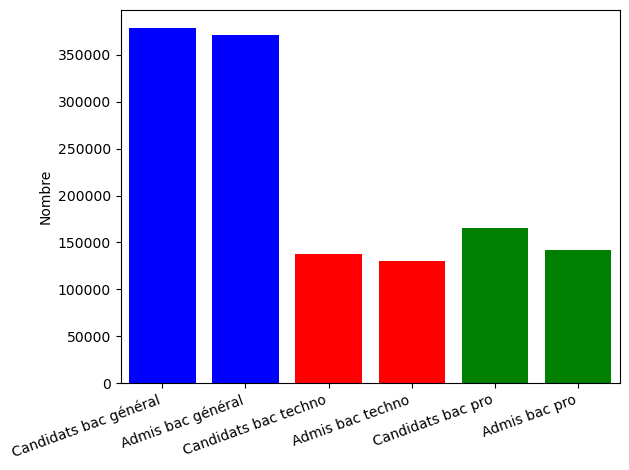

In [30]:
df[["Nombre d'élèves présents au Bac_GNLE","Taux de réussite bruts_GNLE","Nombre d'élèves présents au Bac_Somme Techno","Taux de réussite bruts_Taux brut techno","Nombre d'élèves présents au Bac_TOTAL_Pro","Taux de réussite bruts_TOTAL_Pro"]] 
nbg = df["Nombre d'élèves présents au Bac_GNLE"].sum()
nbgr = np.sum(df["Nombre d'élèves présents au Bac_GNLE"]*df["Taux de réussite bruts_GNLE"])/100
nbt = df["Nombre d'élèves présents au Bac_Somme Techno"].sum()
nbtr = np.sum(df["Nombre d'élèves présents au Bac_Somme Techno"]*df["Taux de réussite bruts_Taux brut techno"])/100
nbp = df["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum()
nbpr = np.sum(df["Nombre d'élèves présents au Bac_TOTAL_Pro"]*df["Taux de réussite bruts_TOTAL_Pro"])/100
plt.bar(["Nombre candidats au baccalauréat général", "Nombre d'élèves ayant réussi le bac général", "Nombre d'élèves présents à un baccalauréat technologique", "Nombre d'élèves ayant réussi un baccalauréat technologique", "Nombre d'élèves présents au bac professionnel", "Nombre d'élèves ayant réussi un baccalauréat professionnel"],[nbg, nbgr, nbt, nbtr, nbp, nbpr], color =['Blue', 'blue', 'red','red','green','green'])
ax = sns.countplot(x=["Candidats bac général", "Admis bac général", "Candidats bac techno", "Admis bac techno", "Candidats bac pro", "Admis bac pro"], data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
plt.tight_layout()
plt.ylabel('Nombre')
plt.show()

Tout d'abord, nous pouvons voir qu'il y'a largament davantage de candidats en filière générale que dans les autres filières. Il y a légèrement plus de candidats en baccalauréat professionnel qu'en baccalauréat technologique. Enfin, le nombre d'admis est proche du nombre de candidats dans toutes les filières, même si l'écart est légèrement plus marqué dans la filière professionnelle.

### B - Une première approche des inégalités régionales

Afin d'appronfondir les remarques faites précédemment, nous allons maintenant étudier la répartition des taux de réussite et des revenus entre les différentes académies françaises.

Pour ce faire, nous faisons des diagrammes en barre. Commençons par le taux de réussite par académie selon la filière du baccalauréat. 

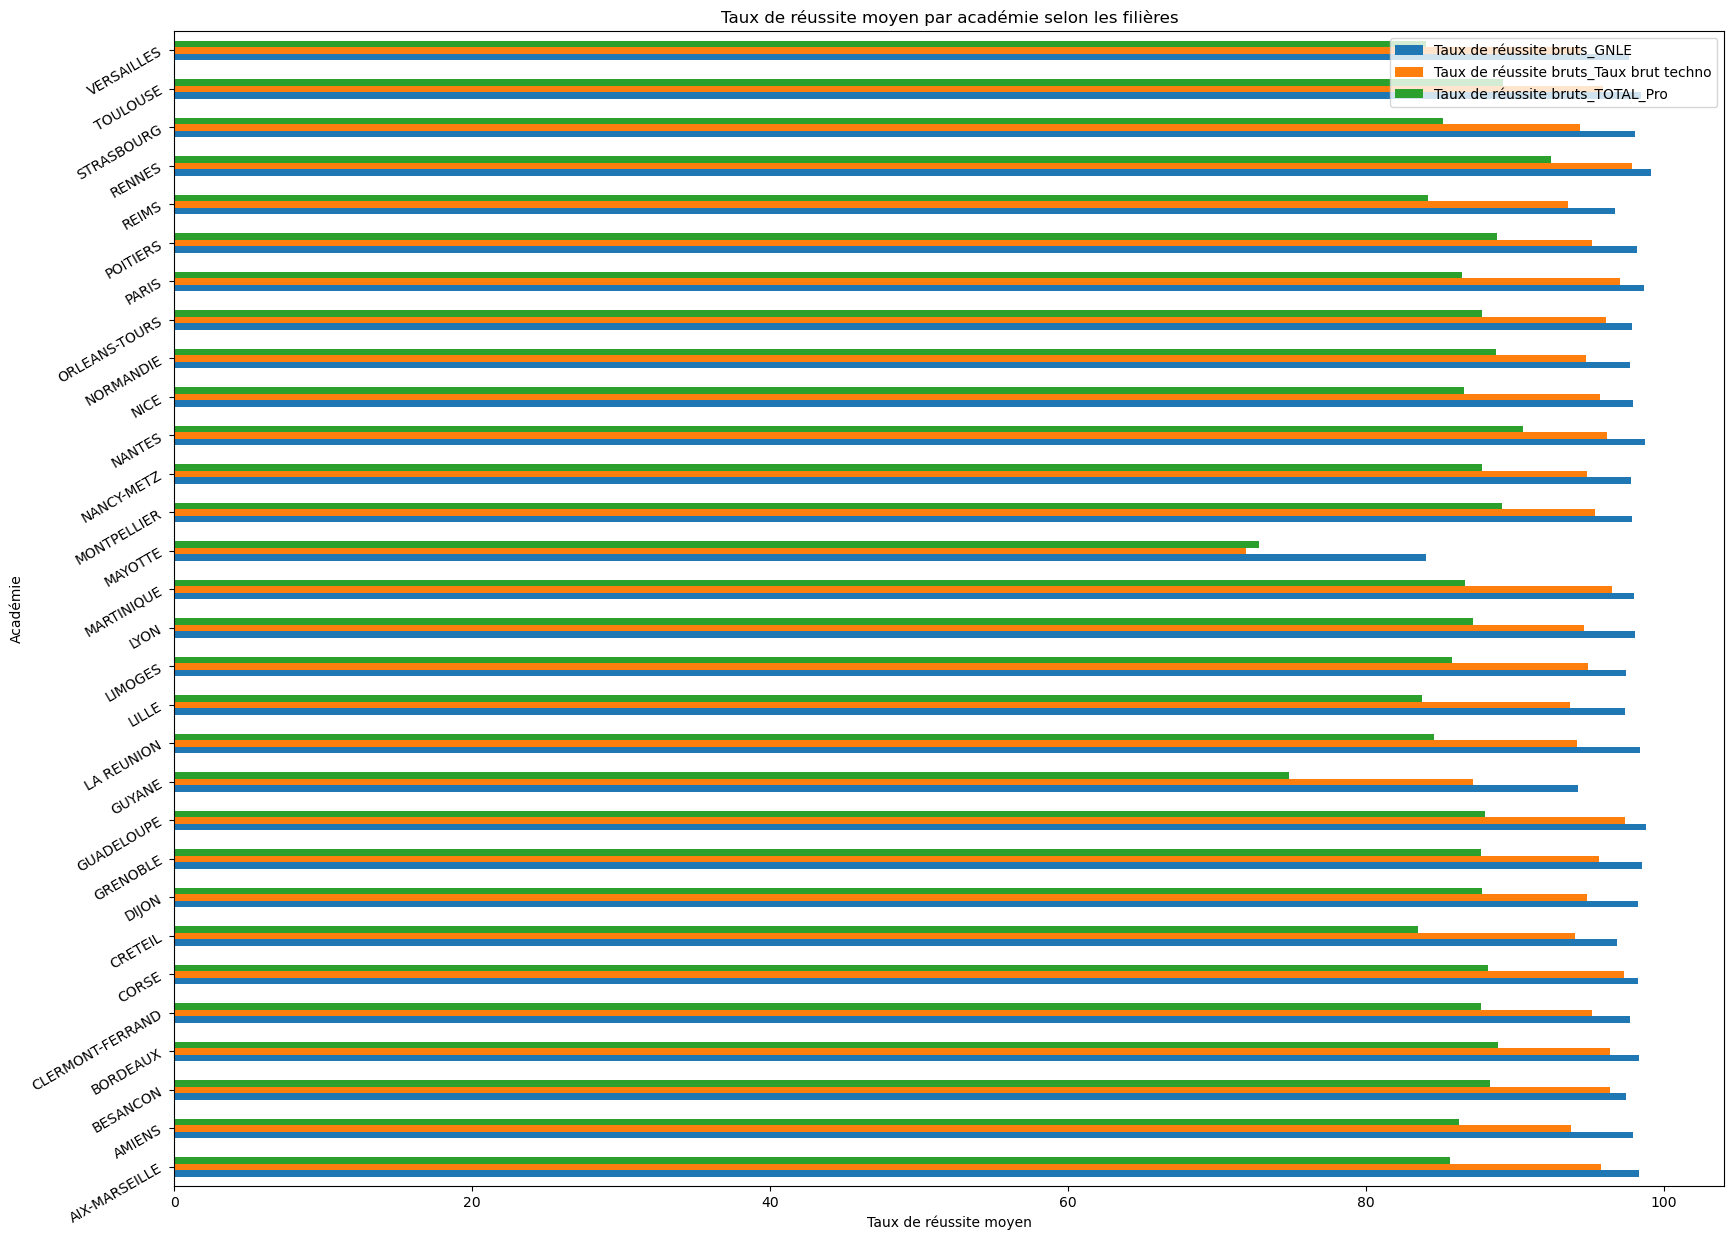

In [31]:
df_barres = df.groupby ("Informations établissement_Académie").agg({"Taux de réussite bruts_GNLE":"mean", "Taux de réussite bruts_Taux brut techno":"mean", "Taux de réussite bruts_TOTAL_Pro":"mean"})
df_barres

df_barres.plot(kind = "barh", rot = 30, figsize = [20,15], title = "Taux de réussite moyen par académie selon les filières", xlabel = "Taux de réussite moyen", ylabel = "Académie")
plt.show()

Tout d'abord, nous observons, comme précédemment, que les taux de réussite pour le bac général sont plus élevés que pour le bac technologique, eux mêmes plus élevés que pour le bac professionnel.

De plus, nous remarquons que les taux de réussite sont sensiblement moins élevés dans les outre-mer, notamment en Guyane et à Mayotte. C'est donc handicapant pour notre projet de ne pas avoir aux données sur les revenus de ces territoires. 

Des inégalités géographiques apparaissent aussi au sein de la métropole. Nous pouvons remarquer que les taux de réussite sont plus faibles à Créteil qu'à Versailles, or on pourra sans doute prouver que le revenu médian est très différent entre ces deux académies.

Au-delà de cela, nous pouvons constater que les taux de réussite restent très stables entre académie donc il sera peut-être difficile de trouver une corrélation avec le revenu médian.

Représentons à présent la répartition des revenus médians selon les académies.

<AxesSubplot: title={'center': 'Moyenne du revenu médian des ménages de chaque commune par académie'}, xlabel='Moyenne des revenus médians', ylabel='Académie'>

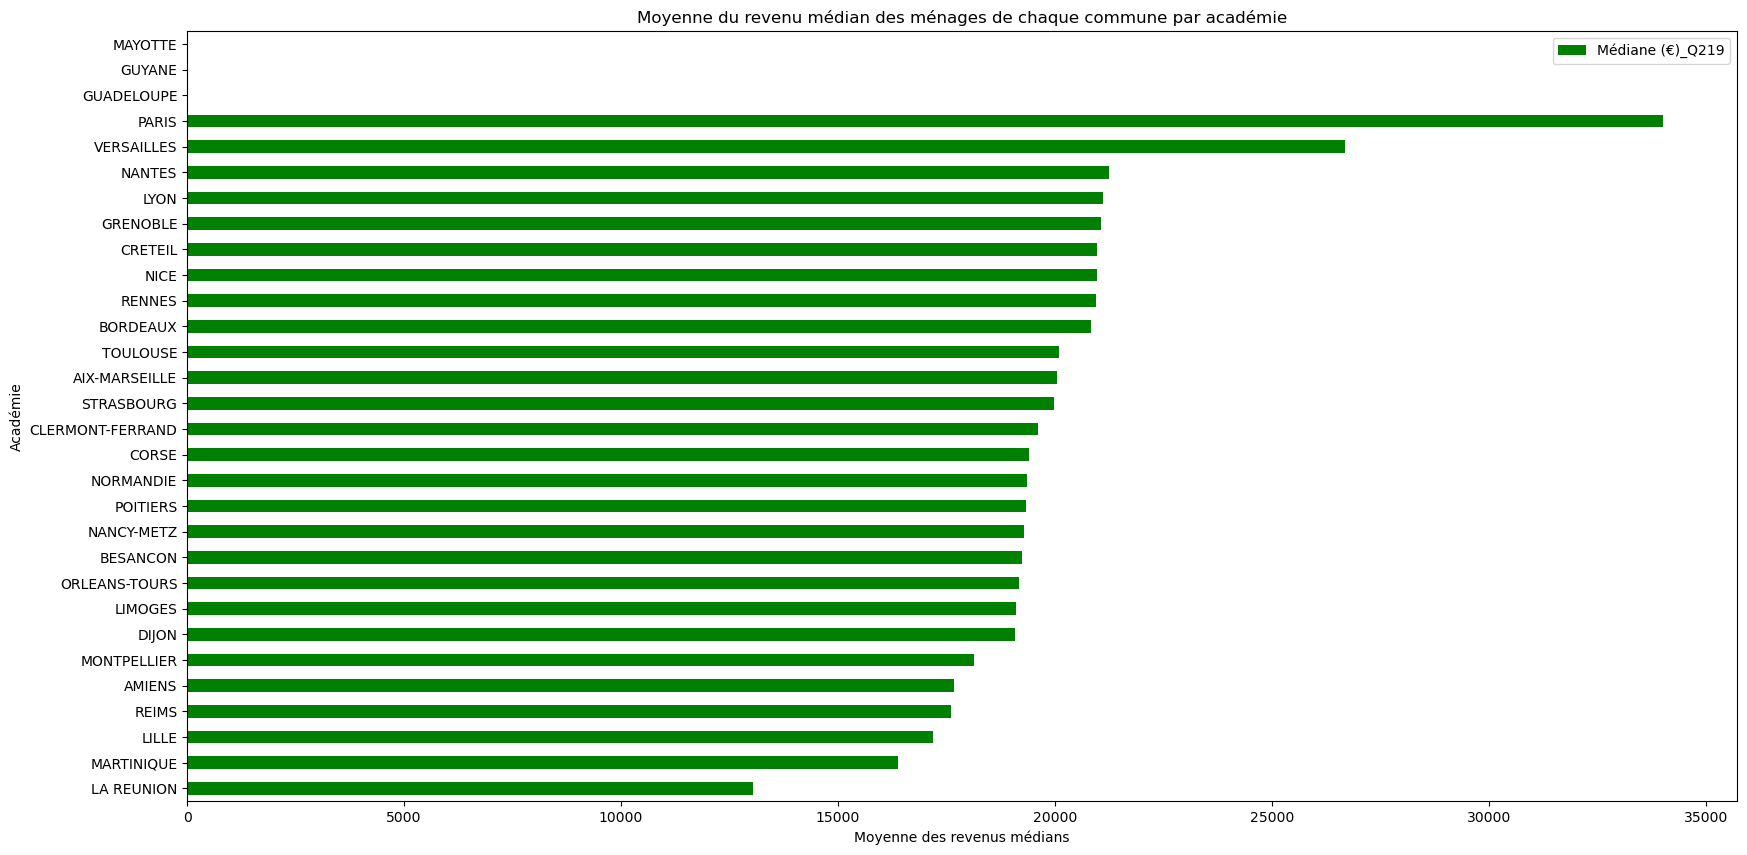

In [32]:
df2 = df.groupby ("Informations établissement_Académie").agg({"Médiane (€)_Q219":"mean"})
p2 = df2.sort_values ("Médiane (€)_Q219").plot (kind="barh", figsize = (20,10), color='green', title = "Moyenne du revenu médian des ménages de chaque commune par académie", xlabel = "Moyenne des revenus médians", ylabel = "Académie")
p2

Ce diagramme nous permet d'identifier les académies les plus riches et les académies les plus pauvres. En tête, nous retrouvons Paris et Versailles et en queue de classement, nous retrouvons les deux outre-mer pour lesquelles nous avons des données (la Réunion et la Martinique).

### C - Une approche plus fine par les déciles

Dans cette sous-partie, nous passons à un découpage en fonction du revenu de la commune où se trouve la commune pour identifier les inégalités économiques. Nous allons chercher à comparer par déciles la répartition des choix de filières ainsi que les taux de réussite aux bacs. 

Pour commencer, nous allons créer des DataFrames par déciles.

In [33]:
#Préparation de bases de données pour travailler par déciles
q1 = df_SDM['Médiane (€)_Q219'].quantile(0.1)
q2 = df_SDM['Médiane (€)_Q219'].quantile(0.2)
q3 = df_SDM['Médiane (€)_Q219'].quantile(0.3)
q4 = df_SDM['Médiane (€)_Q219'].quantile(0.4)
q5 = df_SDM['Médiane (€)_Q219'].quantile(0.5)
q6 = df_SDM['Médiane (€)_Q219'].quantile(0.6)
q7 = df_SDM['Médiane (€)_Q219'].quantile(0.7)
q8 = df_SDM['Médiane (€)_Q219'].quantile(0.8)
q9 = df_SDM['Médiane (€)_Q219'].quantile(0.9)

df1 = df_SDM[df_SDM['Médiane (€)_Q219']<q1] #Premier décile
df2 = df_SDM[df_SDM['Médiane (€)_Q219']>=q1] 
df2 = df2[df2['Médiane (€)_Q219']<q2] #Deuxième décile
df3 = df_SDM[df_SDM['Médiane (€)_Q219']>=q2] 
df3 = df3[df3['Médiane (€)_Q219']<q3]
df4 = df_SDM[df_SDM['Médiane (€)_Q219']>=q3] 
df4 = df4[df4['Médiane (€)_Q219']<q4]
df5 = df_SDM[df_SDM['Médiane (€)_Q219']>=q4] 
df5 = df5[df5['Médiane (€)_Q219']<q5]
df6 = df_SDM[df_SDM['Médiane (€)_Q219']>=q5] 
df6 = df6[df6['Médiane (€)_Q219']<q6]
df7 = df_SDM[df_SDM['Médiane (€)_Q219']>=q6] 
df7 = df7[df7['Médiane (€)_Q219']<q7]
df8 = df_SDM[df_SDM['Médiane (€)_Q219']>=q7] 
df8 = df8[df8['Médiane (€)_Q219']<q8]
df9 = df_SDM[df_SDM['Médiane (€)_Q219']>=q8] 
df9 = df9[df9['Médiane (€)_Q219']<q9]
df10 = df_SDM[df_SDM['Médiane (€)_Q219']>=q9]

Puis, on calcule, pour chaque baccalauréat, le nombre le nombre de candidats et les taux de réussite pondérés par décile.

In [34]:
listedf = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
taux_gen = []
taux_tech = []
taux_pro = []
taux_reussite_total =[]
taux_rgen = []
taux_rtech = []
taux_rpro = []

for elem in listedf:
    #Effectifs totaux par filières + total
    nbg = elem["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum()
    nbt = elem["Nombre d'élèves présents au Bac_Somme Techno"].sum()
    nbp = elem["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum()
    nb = nbp + nbg + nbt
    #Calcul tes taux de candidatures 
    tcg = nbg/nb
    tct = nbt/nb
    tcp = nbp/nb
    #Taux de réussites par filières + total
    trg = (elem["Taux de réussite bruts_GNLE"] * elem["Nombre d'élèves présents au Bac_TOTAL_LGT"]).sum()/nbg
    trt = (elem["Taux de réussite bruts_Taux brut techno"] * elem["Nombre d'élèves présents au Bac_Somme Techno"]).sum()/nbt
    trp = (elem["Taux de réussite bruts_TOTAL_Pro"] * elem["Nombre d'élèves présents au Bac_TOTAL_Pro"]).sum()/nbp
    tr = ((elem["Taux de réussite bruts_TOTAL_Pro"] * elem["Nombre d'élèves présents au Bac_TOTAL_Pro"]).sum()+(elem["Taux de réussite bruts_Taux brut techno"] * elem["Nombre d'élèves présents au Bac_Somme Techno"]).sum()+(elem["Taux de réussite bruts_GNLE"] * elem["Nombre d'élèves présents au Bac_TOTAL_LGT"]).sum())/nb
    #On stocke les éléments dans des listes 
    taux_gen.append(tcg)
    taux_tech.append(tct)
    taux_pro.append(tcp)
    taux_rgen.append(trg)
    taux_rtech.append(trt)
    taux_rpro.append(trp)
    taux_reussite_total.append(tr)

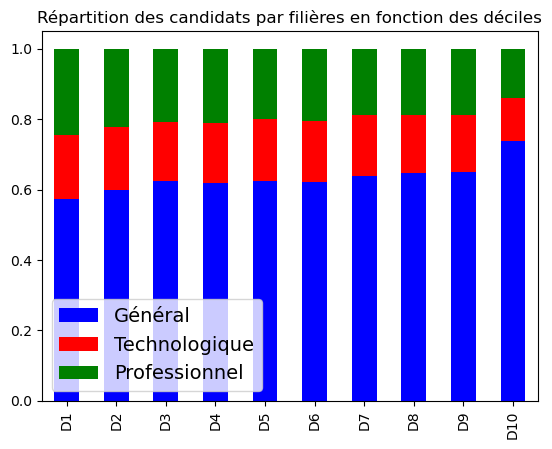

In [35]:
#On crée alors un graphique

dfbar = pd.DataFrame(dict(Général=taux_gen, Technologique=taux_tech, Professionnel=taux_pro))
dfbar = dfbar.rename(index={0:'D1',1:'D2',2:'D3',3:'D4',4:'D5',5:'D6',6:'D7',7:'D8',8:'D9',9:'D10'})
ax = dfbar.plot.bar(stacked=True, color=['blue', 'red','green'])
plt.title("Répartition des candidats par filières en fonction des déciles")
h,l = ax.get_legend_handles_labels()
ax.legend(h[:3],["Général", "Technologique", "Professionnel"], loc=3, fontsize=14)
plt.show()


On s'aperçoit que la part de candidats dans la filière générale augmente au fur et à mesure entre les déciles, surtout entre le neuvième et le dernier décile. La part de la filière technologique suit la trajectoire inverse. Dans les neufs premiers déciles, la part de potentiels Bacheliers technologiques reste stable et se réduit dans le dernier décile. 

Le revenu semble sont avoir une influence sur le choix de la filière. Plus on est dans un décile de revenu élevé, plus on a de chance de suivre une filière valorisée socialement.

On va désormais s'intéresser au taux de réussite au bac en fonction des filières et des déciles. 

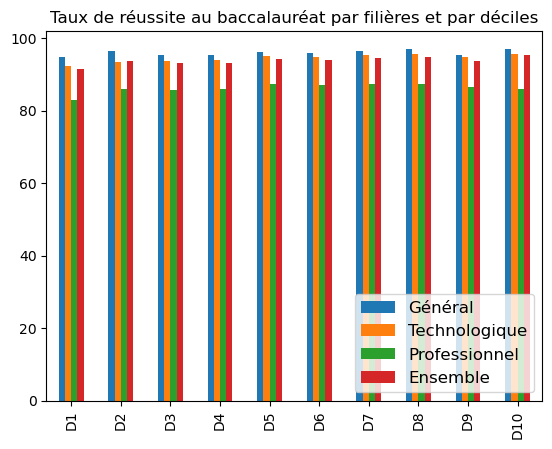

In [36]:
dfbar2 = pd.DataFrame(dict(Général=taux_rgen, Technologique=taux_rtech, Professionnel = taux_rpro, Ensemble=taux_reussite_total))
dfbar2 = dfbar2.rename(index={0:'D1',1:'D2',2:'D3',3:'D4',4:'D5',5:'D6',6:'D7',7:'D8',8:'D9',9:'D10'})
ax2 = dfbar2.plot.bar()
plt.title("Taux de réussite au baccalauréat par filières et par déciles")
h,l = ax2.get_legend_handles_labels()
ax2.legend(h[:4],["Général", "Technologique", "Professionnel", "Ensemble"], loc=4, fontsize=12)
plt.show()


En terme de réussite, on ne voit pas de différences flagrantes entre les déciles. Plusieurs explications sont possibles :
- Le revenu n'influence pas la réussite au baccalauréat. (Cette explication demeure étonnante au regard des résultats montrés par la sociologie de l'éducation). 
- Etant donné que les élèves sont déjà triés dans les filières associées à leur milieu social, ils réussissent à avoir leur baccalauréat dans les mêmes proportions.
- On est face à une limite de notre hypothèse initiale : associer le niveau de revenu des élèves à celui du revenu médian de la commune dans laquelle se trouve leur établissement scolaire. 

## III - Visualisation des données-cartes interactives

Cette partie a pour objectif d'approfondir la visualisation de nos données en permettant d'avoir des éléments plus fin de comparaison géographique au sein des académies et des départements. 
Elle a aussi un aspect ludique car elle permet de connaître le revenu médian de sa commune et comparer son lycée aux lycées environnants. 

**Pour avoir directement les cartes** (la partie du notebook met quelques minutes à s'exécuter):

In [37]:
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/carte_sans_outre_mer.html
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/carte_public_prive.html
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/carte_taux_reussite.html

### A - Ouverture et traitement des bases de données utilisées pour les cartes ###

On utilise une base de données issue de data.gouv pour les contours des communes qui est bien plus légère que la version cartiflette.
On a initialement essayé de récupérer les contours des communes avec Cartiflette mais le fichier qui en résulte est trop lourd (environ 1Go). De plus, l'installation de cartiflette crée des conflits de version sur d'autres packages/sous-packages.

In [38]:
df_cartes1 = pd.read_excel("base_def_SansDOMTOM.xlsx") #pour l'instant doit executer fichier manipulation bases avant pour l'avoir
leger = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/a7424932-4585-4ee8-a24b-78535710ca99") #fichier beaucoup plus léger que celui généré par cartiflette
df_cartes = df_cartes1.drop("Unnamed: 0", axis=1)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


Si les données ne sont plus accessibles, pour la reproductibilité du projet, les données que nous avons utilisées peuvent être importées comme ceci:

In [39]:
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/a-com2022-topo.json

On enlève les départements d'outre mer car ils ont été déplacés dans le fichier des contours (pour pouvoir faire des cartes où ils sont visibles), ce qui rend le traitement compliqué.

In [40]:
outre_mer = ["971", "972", "973", "974", "976"]
for i in outre_mer:
    leger = leger[leger["dep"] != i]

On enlève les variables inutiles et les villes qui ont des arrondissements (on va remettre les arrondissements ensuite)

In [41]:
leger = leger[["codgeo", "geometry"]]
leger2 = leger[leger["codgeo"] != "75056"]
leger3 = leger2[leger2["codgeo"] != "69123"]
leger4 = leger3[leger3["codgeo"] != "13055"]
leger.info()
leger4.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 34826 entries, 0 to 34954
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   codgeo    34826 non-null  object  
 1   geometry  34826 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 816.2+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 34823 entries, 0 to 34954
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   codgeo    34823 non-null  object  
 1   geometry  34823 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 816.2+ KB


on va rajouter les arrondissements de ces villes (le fait d'avoir des bases de données différentes fait que les contours ne s'emboîtent pas exactement mais ce n'est pas un soucis dans le cadre de notre projet. Voici les liens pour télécharger directement les données si besoin (pour la reproductibilité du projet):

In [42]:
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/arr_paris.geojson
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/arr_lyon.json
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/arr_marseille.geojson

In [43]:
arr_paris = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
arr_paris2 = arr_paris[["c_arinsee", "geometry"]]
arr_paris3 = arr_paris2.rename(columns={"c_arinsee" : "codgeo"})
avec_paris = gpd.GeoDataFrame( pd.concat( [leger4, arr_paris3], ignore_index=True) )
avec_paris.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34843 entries, 0 to 34842
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   codgeo    34843 non-null  object  
 1   geometry  34843 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 544.5+ KB


/opt/mamba/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [44]:
arr_lyon = gpd.read_file("https://transcode.geo.data.gouv.fr/services/5e2a1e77fa4268bc255379c2/feature-types/ms:adr_voie_lieu.adrarrond?format=GeoJSON&projection=WGS84")
arr_lyon2 = arr_lyon[["insee", "geometry"]]
arr_lyon3 = arr_lyon2.rename(columns={"insee" : "codgeo"})
avec_lyon = gpd.GeoDataFrame( pd.concat( [avec_paris, arr_lyon3], ignore_index=True) )
avec_lyon.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34852 entries, 0 to 34851
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   codgeo    34852 non-null  object  
 1   geometry  34852 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 544.7+ KB


In [45]:
arr_marseille = gpd.read_file("https://data.ampmetropole.fr/explore/dataset/contours-geographiques-des-communes-et-arrondissements-municipaux/download/?format=geojson&refine.nom_com=Marseille&timezone=Europe/Berlin&lang=fr")
arr_marseille2 = arr_marseille[["insee_com", "geometry"]]
arr_marseille3 = arr_marseille2.rename(columns={"insee_com" : "codgeo"})
avec_tout = gpd.GeoDataFrame( pd.concat( [avec_lyon, arr_marseille3], ignore_index=True) )
avec_tout.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34868 entries, 0 to 34867
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   codgeo    34868 non-null  object  
 1   geometry  34868 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 544.9+ KB


On convertit la base de données des lycées en geopandas pour que la géométrie soit facilement utilisable.

In [46]:
gdf = gpd.GeoDataFrame(
    df_cartes, geometry=gpd.points_from_xy(df_cartes.longitude, df_cartes.latitude))

On reprend le fichier des communes pour les données de revenu pour ne pas avoir que celles qui ont un lycée. Ceci est intéressant car les élèves d'un lycée ne viennent pas exclusivement de cette commune mais aussi des communes environnantes (les données de carte scolaire ne sont hélas pas disponibles pour les lycées). 

In [47]:
df_com = pd.read_excel("base_communes.xlsx") 

On convertit le fichier pour que Chorropleth prenne le bon identifiant.

In [48]:
leger_json_with_id = avec_tout.set_index(keys = "codgeo").to_json()

### B - Utilisation de folium pour générer des cartes interactives

Dans cette partie, nous générons plusieurs cartes interactives pour étudier la répartition des lycées et des taux de réussite selon de le revenu médian de la commune dont ils dépendent. 

Pour ce faire, nous créeons une fonction qui permet de rajouter une couche où la couleur de chaque commune dépend du niveau de revenu médian. Puisque l'opération est répétée régulièrement, il est utile de faire une fonction.

In [49]:
def choro(m):
    folium.Choropleth(
        geo_data=leger_json_with_id,
        data=df_com,
        columns=["Code géographique_CODGEO", "Médiane (€)_Q219"],
        key_on= "feature.id",
        bins=12, #définit le nombre de catégories de couleur
        smooth_factor= 0.2, #niveau de détails du polygone des communes, 1=max, nous n'avons pas besoin que très détaillé
        fill_color="BuPu", #couleurs
        fill_opacity=0.7, 
        line_opacity=.25, #oppacité des séparations entre communes
        legend_name="Revenu médian de la commune en euros",
        name = "Revenus médians des communes",
        prefer_canvas = True,
        highlight = True
    ).add_to(m)
    folium.LayerControl().add_to(m)
    


A noter qu'il manque des données pour les revenus de certaines communes mais ça ne pose pas vraiment problème pour la visualisation cartographique car ce sont en général des communes rurales sans lycées.

Par ailleurs, on limite le nombre de couches car les cartes sont déjà très lourdes.

#### a) Carte séparant les lycées professionels des autres ####

Cette carte nous permet d'étudier la répartition des lycées généraux, technologiques et professionnels et de la comparer aux revenus des communes où ils se situent.

On utilise un fond de carte standard et on choisit arbitrairement de centrer initialement la carte intéractive sur la région parisienne.


In [50]:
map_1 = folium.Map(location=[48.8, 2.19], zoom_start=9, control_scale= True, prefer_canvas = True) 
#prefer_canvas accélère l'utilisation de la carte

On rajoute la couche des communes colorées par revenus.

In [51]:
choro(map_1)

On rajoute des marqueurs pour chaque lycée, en séparant par couleur entre les lycées généraux et technologiques et les lycées professionnels.
On rajoute un popup qui donne le nom du lycée et les taux de réussite au bac.

In [52]:
#On pourrait en faire une fonction mais compliqué car change beaucoup
# Create a geometry list from the GeoDataFrame
gdf_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry] #pourrait faire cette opération qu'une fois pour toutes les cartes


# Iterate through list and add a marker for lycée, color-coded by its type.
i = 0
for coordinates in gdf_list:
    #Assigner une couleur de marqueur selon le type de lycée
    if gdf["Nombre d'élèves présents au Bac_TOTAL_LGT"][i] > 0.5:
     #Général et techno (on pourrait séparer en général et techno si on veut)
        html=f"""
        <h5> {gdf["Informations établissement_Etablissement"][i]}</h5>
        <p>Taux de réussite global: {gdf["Taux de réussite bruts_TOTAL_LGT"][i]} </p>
        <ul>
            <li>Taux de réussite filières générales: {gdf["Taux de réussite bruts_GNLE"][i]}</li>
            <li>Taux de réussite filières techno: {gdf["Taux de réussite bruts_Taux brut techno"][i]}</li>
        </ul>
        """
        iframe = folium.IFrame(html=html, width=200, height=200)
      
        map_1.add_child(
            folium.Marker(
                location=coordinates,
                popup= folium.Popup(iframe, max_width=2650),
                icon=folium.Icon(color="green"),
            )
        )
    else:
     #Pro
        html=f"""
        <h5> {gdf["Informations établissement_Etablissement"][i]}</h5>
        <p>Taux de réussite global: {gdf["Taux de réussite bruts_TOTAL_Pro"][i]} </p>
        """
        iframe = folium.IFrame(html=html, width=200, height=125)
        map_1.add_child(
            folium.Marker(
                location=coordinates,
                popup=folium.Popup(iframe, max_width=2650) ,
                icon=folium.Icon(color="red"),
            )
        )

    
    i = i + 1

Cette cellule permet d'afficher la carte (mais on évite car elle est lourde et que cela fait facilement bugger le notebook). 
Quand on ouvre la carte dans jupyter il faut "thrust html"

In [53]:
#map

On enregistre la carte.

In [54]:
map_1.save(outfile ='carte_sans_outre_mer.html') 

On a un certain problème de poids lié principalement au choropleth (le fond de carte seul fait quelques ko et les marqueurs+fond 6Mo, la carte totale en fait quasiment 60...). 

**Fonctionnalités de la carte et résultats**  
Le fond de la carte est un fond google map. La couche "Revenus médians des communes" donne les communes colorées par niveau de revenu médian. Les marqueurs correspondent aux lycées, rouge pour les lycées professionels et vert pour les lycées généraux et technologiques. En cliquant sur un marqueur on obtient le nom du lycée et des informations sur les taux de réussite au bac.

**Exemple**  
Visuellement on observe des différences marquées selon le revenu des communes.  
Par exemple entre Neuilly sur Seine (qui est dans une des tranches de revenus les plus élevées) et Saint-Denis (qui est dans une une des tranches de revenus les plus basses): à Neuilly sur Seine il y a 5 lycées généraux et technologiques et deux lycées professionels alors qu'à Saint-Denis il y a 5 lycées professionels et seulement 1 lycée général et technologique.

#### b) Carte séparant les lycées publics des lycées privés ####

Similairement, cette carte nous permet d'étudier la répartition des lycées publics et privés en fonction du revenu médian de la commune où ils sont implentés. 

On génère à nouveau une carte avec juste un fond centrée sur la région parisienne.

In [55]:
map_2 = folium.Map(location=[48.8, 2.19], zoom_start=9, control_scale= True, prefer_canvas = True) 
#prefer_canvas accélère l'utilisation de la carte

On rajoute le choropleth par revenu des communes.

In [56]:
choro(map_2)

On rajoute les marqueurs pour les lycées en différentiant cette fois-ci en plus selon si le lycée est privé ou public (couleur foncée ou claire).

In [57]:
# Create a geometry list from the GeoDataFrame
gdf_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry]


# Iterate through list and add a marker for lycée, color-coded by its type.
i = 0
for coordinates in gdf_list:
    # Assigner une couleur de marqueur selon le type de lycée
    if gdf["Nombre d'élèves présents au Bac_TOTAL_LGT"][i] > 0.5:
     #Général et techno (on pourrait séparer en général et techno si on veut)
        html=f"""
        <h5> {gdf["Informations établissement_Etablissement"][i]}</h5>
        <p>Taux de réussite global: {gdf["Taux de réussite bruts_TOTAL_LGT"][i]} </p>
        <ul>
            <li>Taux de réussite filières générales: {gdf["Taux de réussite bruts_GNLE"][i]}</li>
            <li>Taux de réussite filières techno: {gdf["Taux de réussite bruts_Taux brut techno"][i]}</li>
        </ul>
        """
        iframe = folium.IFrame(html=html, width=200, height=200)
        if gdf["Informations établissement_Secteur"][i] == "PU":
            icon_color ="lightgreen"
        elif gdf["Informations établissement_Secteur"][i] == "PR":
            icon_color ="darkgreen"
      
        map_2.add_child(
            folium.Marker(
                location=coordinates,
                popup= folium.Popup(iframe, max_width=2650),
                icon=folium.Icon(color=icon_color),
            )
        )
    else:
     #Pro
        html=f"""
        <h5> {gdf["Informations établissement_Etablissement"][i]}</h5>
        <p>Taux de réussite global: {gdf["Taux de réussite bruts_TOTAL_Pro"][i]} </p>
        """
        iframe = folium.IFrame(html=html, width=200, height=125)
        if gdf["Informations établissement_Secteur"][i] == "PU":
            icon_color ="lightred"
        elif gdf["Informations établissement_Secteur"][i] == "PR":
            icon_color ="darkred"
        map_2.add_child(
            folium.Marker(
                location=coordinates,
                popup=folium.Popup(iframe, max_width=2650) ,
                icon=folium.Icon(color=icon_color),
            )
        )
    
    i = i + 1


On enregistre la carte.

In [58]:
map_2.save(outfile ='carte_public_prive.html') 

**Fonctionnalités de la carte et résultats**  
Les fonctionnalités sont les mêmes que pour la carte précédente sauf pour les marqueurs. Ici les marqueurs rouge clair représentent les lycées professionels publics, les marqueurs rouge foncé les lycées professionels privés, les marqueurs vert clair les lycées généraux et technologiques publics et les marqueurs vert foncé les lycées généraux et technologiques privés.

**Exemple**  
Visuellement on observe des différences marquées selon le revenu des communes.
Par exemple entre Saint-Germain en Laye (qui est dans une des tranches de revenus les plus élevées) et Champigny sur Marne (qui est dans une une des tranches de revenus les plus basses): à Saint-Germain en Laye il y a 5 lycées privés et 4 lycées publics alors qu'à Champigny sur Marne les 4 lycées sont tous publics.

#### c) Carte séparant les lycées selon les quantiles de taux de réussite au bac ####

Cette carte nous permet d'étudier la répartition des taux de réussite aux différents baccalauréat.

Comme précédement on génère une carte avec un choropleth des revenus médians des communes.

In [59]:
map_3 = folium.Map(location=[48.8, 2.19], zoom_start=9, control_scale= True, prefer_canvas = True) 
choro(map_3)

On reprend les quantiles vus dans les statistiques descriptives.

In [60]:
gdf["Taux de réussite bruts_TOTAL_LGT"].quantile(q= [0.25, 0.5, 0.75])

0.25     96.0
0.50     98.0
0.75    100.0
Name: Taux de réussite bruts_TOTAL_LGT, dtype: float64

In [61]:
gdf["Taux de réussite bruts_TOTAL_Pro"].quantile(q = [0.25, 0.5, 0.75])

0.25    82.0
0.50    88.0
0.75    94.0
Name: Taux de réussite bruts_TOTAL_Pro, dtype: float64

On rajoute des marqueurs en séparant par quantiles de taux de réussite au bac (3 couleurs différentes par type de lycée).

In [62]:
# Create a geometry list from the GeoDataFrame
gdf_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry]
# Iterate through list and add a marker for lycée, color-coded by its type.
i = 0
for coordinates in gdf_list:
    # Assigner une couleur de marqueur selon le type de lycée
    if gdf["Nombre d'élèves présents au Bac_TOTAL_LGT"][i] > 0.5:
     #Général et techno (on pourrait séparer en général et techno si on veut)
        html=f"""
        <h5> {gdf["Informations établissement_Etablissement"][i]}</h5>
        <p>Taux de réussite global: {gdf["Taux de réussite bruts_TOTAL_LGT"][i]} </p>
        <ul>
            <li>Taux de réussite filières générales: {gdf["Taux de réussite bruts_GNLE"][i]}</li>
            <li>Taux de réussite filières techno: {gdf["Taux de réussite bruts_Taux brut techno"][i]}</li>
        </ul>
        """
        iframe = folium.IFrame(html=html, width=200, height=200)
        if gdf["Taux de réussite bruts_TOTAL_LGT"][i] < gdf["Taux de réussite bruts_TOTAL_LGT"].quantile(0.25):
            icon_color ="lightgreen"
        elif gdf["Taux de réussite bruts_TOTAL_LGT"][i] < gdf["Taux de réussite bruts_TOTAL_LGT"].quantile(0.5):
            icon_color ="green"
        else:
            icon_color = "darkgreen" 
        # Choix des quantiles lié stats desc
      
        map_3.add_child(
            folium.Marker(
                location=coordinates,
                popup= folium.Popup(iframe, max_width=2650),
                icon=folium.Icon(color=icon_color),
            )
        )
    else:
     #Pro
        html=f"""
        <h5> {gdf["Informations établissement_Etablissement"][i]}</h5>
        <p>Taux de réussite global: {gdf["Taux de réussite bruts_TOTAL_Pro"][i]} </p>
        """
        iframe = folium.IFrame(html=html, width=200, height=125)
        if gdf["Taux de réussite bruts_TOTAL_Pro"][i] < gdf["Taux de réussite bruts_TOTAL_Pro"].quantile(0.25):
            icon_color ="lightred"
        elif gdf["Taux de réussite bruts_TOTAL_Pro"][i] < gdf["Taux de réussite bruts_TOTAL_Pro"].quantile(0.5):
            icon_color ="red"
        else:
            icon_color = "darkred"
        #Ici serait pertinent d'en avoir quatre différent car stats plus dispersées...
        map_3.add_child(
            folium.Marker(
                location=coordinates,
                popup=folium.Popup(iframe, max_width=2650) ,
                icon=folium.Icon(color=icon_color),
            )
        )
 
    
    i = i + 1

On enregistre le fichier

In [63]:
map_3.save(outfile ='carte_taux_reussite.html')

**Fonctionnalités de la carte**  
Les fonctionnalités sont les mêmes que pour la première carte sauf pour les marqueurs. Ici les marqueurs rouge clair représentent les lycées professionnels avec un taux de réussite dans le premier quartile, les marqueurs rouge moyen les lycées professionnels avec un taux de réussite dans le deuxième quartile, les marqueurs rouge foncé les lycées professionnels avec un taux de réussite supérieur à la médiane, les marqueurs vert clair représentent les lycées généraux et technologiques avec un taux de réussite dans le premier quartile, les marqueurs vert moyen les lycées généraux et technologiques avec un taux de réussite dans le deuxième quartile et les marqueurs vert foncé les lycées généraux et technologiques avec un taux de réussite supérieur à la médiane.


**Exemple**  
Visuellement on observe des différences marquées selon le revenu des communes. Par exemple entre Neuilly sur Seine (qui est dans une des tranches de revenus les plus élevées) et La Courneuve (qui est dans une une des tranches de revenus les plus basses) : à Neuilly sur Seine, les lycées (qu'ils soient généraux et technologiques ou professionels) ont tous des taux de réussite dans la partie supérieure de notre distribution (ce que l'on voit à la couleur des marqueurs qui sont foncés), à La Courneuve, les lycées (qu'ils soient généraux et technologiques ou professionels) ont tous des taux de réussite dans la partie la plus basse de notre distribution (donc des marqueurs clairs).

## IV - La Modélisation

### A - Régression linéaire simple entre revenu et taux de réussite

Bien que nos statistiques descriptives semblent montrer qu'il n'existe pas forcément de corrélation entre le taux de réussite au bac d'un lycée et le revenu médian de la commune dans laquelle il se trouve, les cartes nous montrent que cette hypothèse n'est pas si aberrante.
Nous allons donc la tester à l'aide d'une régression linéaire.

Ainsi, nous réalisons un nuage de points avec le revenu en abscisses et le taux de réussite en ordonnées puis nous ajoutons une droite de régression. Afin de quantifier la pertinence de la régression, nous calculons également le R².

Commençons par réaliser une régression pour le baccalauréat général. 

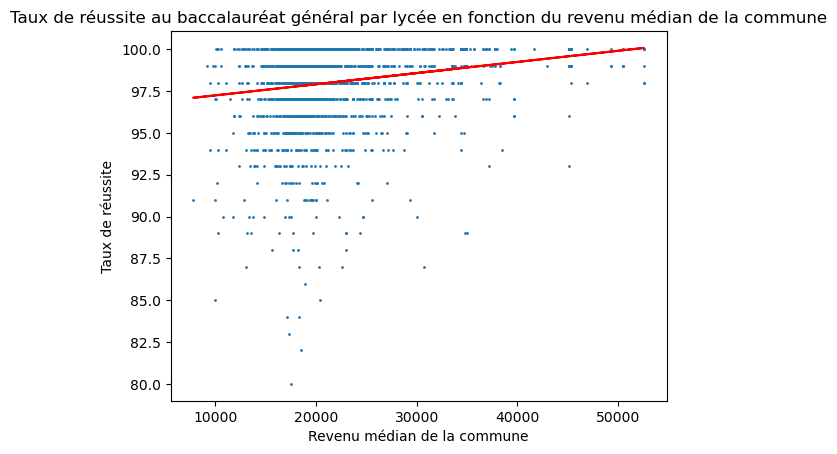

R² =  0.028721644960888026


In [64]:
#Régression pour le général
df_reg = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_GNLE"]]
df_reg = df_reg.dropna(axis = 0, how = "any")
df_reg

x = np.array(df_reg[["Médiane (€)_Q219"]])
y = np.array(df_reg[["Taux de réussite bruts_GNLE"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat général par lycée en fonction du revenu médian de la commune")
plt.xlabel ("Revenu médian de la commune")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (y, y_predicted)
print("R² = ", r2)

D'un premier abord, le nuage de points semble suggérer qu'il peut exister une corrélation car les valeurs extrêmes du taux de réussite au bac se concentrent vers les valeurs les plus faibles du revenu médian. Pour autant, il existe de très nombreux points à 100% de réussite au bac général quel que soit le revenu médian de la commune. La droite de régression est bien croissante et le R², bien que faible, n'est pas nul : nous pouvons donc en déduire qu'il existe une certaine corrélation entre le revenu médian de la commune et le taux de réussite au bac général. Cette corrélation reste faible donc le revenu n'est pas le seul facteur explicatif de la réussite au bac.

Nous réalisons cette régression également pour le bac technologique et professionnel et nous obtenons des résultats similaires et des R² légèrement inférieurs. 

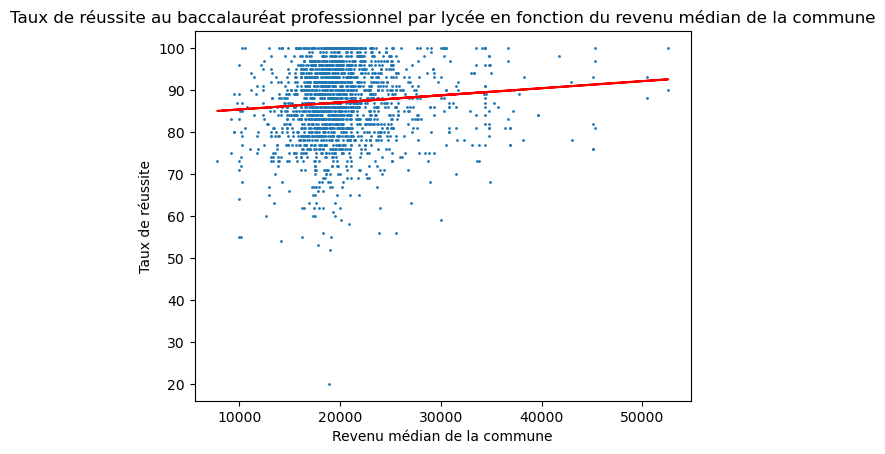

R² =  0.008782981109837995


In [65]:
#Régression pour le professionnel
df_reg_pro = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_TOTAL_Pro"]]
df_reg_pro = df_reg_pro.dropna(axis = 0, how = "any")
df_reg_pro

x = np.array(df_reg_pro[["Médiane (€)_Q219"]])
y = np.array(df_reg_pro[["Taux de réussite bruts_TOTAL_Pro"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat professionnel par lycée en fonction du revenu médian de la commune")
plt.xlabel ("Revenu médian de la commune")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (y, y_predicted)
print("R² = ", r2)

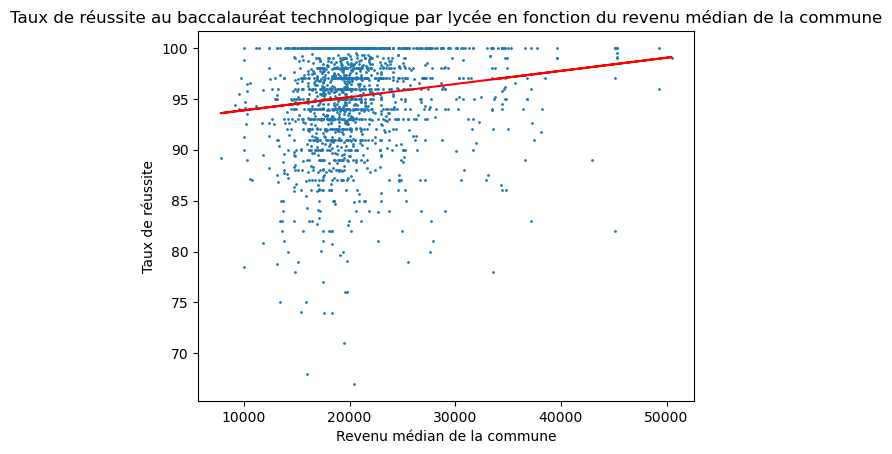

R² =  0.01847083078635514


In [66]:
#Régression pour le technologique
df_reg_techno = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_Taux brut techno"]]
df_reg_techno = df_reg_techno.dropna(axis = 0, how = "any")
df_reg_techno

x = np.array(df_reg_techno[["Médiane (€)_Q219"]])
y = np.array(df_reg_techno[["Taux de réussite bruts_Taux brut techno"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat technologique par lycée en fonction du revenu médian de la commune")
plt.xlabel ("Revenu médian de la commune")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (y, y_predicted)
print("R² = ", r2)

### B - Régression linéaire multiple intégrant l'indice de Gini

Nous avons donc montrer que le revenu n'est pas suffisant pour expliquer les différences de taux de réussite au bac entre les lycées. Nous allons donc faire une régression multiple en intégrant l'indice de Gini. Cet indicateur d'inégalités nous semble pertinent puisque qu'on peut considérer que dans une commune où les inégalités sont plus élevées, la population du lycée sera plus diversifiée en termes d'origine sociale. Ainsi, on peut prédire qu'une commune à haut revenu et faibles inégalités aura de meilleures résutlats au bac qu'une commune plus pauvre où les inégalités sont très marquées.


Testons ces hypothèses pour le taux de réussite au baccalauréat général. 

In [67]:
df_reg_gini = df[[ "Médiane (€)_Q219", "Indice de Gini_GI19", "Taux de réussite bruts_GNLE"]]
df_reg_gini = df_reg_gini.dropna(axis = 0, how = "any")

y = df_reg_gini[["Taux de réussite bruts_GNLE"]]
X = df_reg_gini[["Médiane (€)_Q219", "Indice de Gini_GI19"]]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     Taux de réussite bruts_GNLE   R-squared:                       0.030
Model:                                     OLS   Adj. R-squared:                  0.029
Method:                          Least Squares   F-statistic:                     33.42
Date:                         Wed, 21 Dec 2022   Prob (F-statistic):           5.10e-15
Time:                                 21:19:42   Log-Likelihood:                -4891.8
No. Observations:                         2139   AIC:                             9790.
Df Residuals:                             2136   BIC:                             9807.
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Le coefficient associé à l'indice de Gini n'est pas négligeable et est négatif : il existe donc bien une corrélation entre les inégalités de revenu et de réussite au bac. Suite à une hausse des inégalités, on peut prévoi une baisse du taux de réussite au baccalauréat. Pour autant, l'indice de Gini n'est pas statistiquement significatf (la p-valeur est très élevée). De plus, le R² n'a pas significativement augmenté. 

### C - Régression simple sur le pourcentage de bacs généraux ###

Nos statistiques descriptives et nos cartes nous avez permis d'émettre l'hypothèse qu'il peut être difficile d'établir une corrélation entre revenu et taux de réussite car il existe un mécanisme de sélection sociale pour les filières du baccalauréat. Nous allons donc désormais tester cette hypothèse.

Nous allons faire une régression entre la part de bac généraux dans les présents au bac et une fonction du revenu pour chaque département (la moyenne des médianes des revenus des communes pondérées par le nombre d'habitants de ces communes). Nous n'avons pas le revenu moyen par commune donc le resultat ne sera pas une moyenne ni une médiane (car la somme de médianes n'est pas une médiane) mais nous considèrons que nous obtenons malgré tout un indicateur des revenus raisonnable et peut-être plus pertinent.

Nous reprenenons la base de toutes les communes (pour le calcul de l'indicateur des revenus à l'échelle du département) pour ne pas avoir que celles ayant un lycée. En effet, a priori une forte majorité des élèves du département qui vivent dans des communes sans lycées vont dans un autre lycée du département. 

Nous commençons par créer notre indicateur de revenus (moyenne_mediane_toutes_communes) :

In [68]:
df_com = pd.read_excel("base_communes.xlsx")
test_com = df_com.copy()
test_com["départements"] = [0 for i in range (len(test_com))]
for i in range (len(test_com)):
    test_com["départements"][i]= test_com["Code géographique_CODGEO"][i][:2] #on garde les deux premiers chiffres du code commune pour avoir le code du département
test_com["moyenne mediane"] = test_com["Nbre d'unités de consommation dans les ménages fiscaux_NBUC19"]*test_com["Médiane (€)_Q219"]
test_com_2= test_com.groupby("départements")["moyenne mediane"].sum()
moyenne_mediane_toutes_communes = test_com_2/test_com.groupby("départements")["Nbre d'unités de consommation dans les ménages fiscaux_NBUC19"].sum()


/tmp/ipykernel_493/2473233809.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_com["départements"][i]= test_com["Code géographique_CODGEO"][i][:2] #on garde les deux premiers chiffres du code commune pour avoir le code du département


Puis on prépare un dataframe pour la régression :

In [69]:
df_reg = df.copy()
df_reg["départements"] = [0 for i in range (len(df_reg))]
for i in range (len(df_reg)):
     df_reg["départements"][i]= df_reg["Code_commune"][i][:2] #on garde les deux premiers chiffres du code commune pour avoir le code du département
        
type(df_reg.groupby("départements")["Nombre d'élèves présents au Bac_GNLE"].sum() / (df_reg.groupby("départements")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() + df_reg.groupby("départements")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum()))
x_reg = df_reg.groupby("départements")["Nombre d'élèves présents au Bac_GNLE"].sum() / (df_reg.groupby("départements")["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum() + df_reg.groupby("départements")["Nombre d'élèves présents au Bac_TOTAL_LGT"].sum())

frame = {"Part général dans présence au bac": x_reg, "moyenne_mediane_toutes_communes": moyenne_mediane_toutes_communes}
df_reg = pd.DataFrame(frame)
df_reg = df_reg.dropna(axis = 0, how = "any")
df_reg



/tmp/ipykernel_493/1028368389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg["départements"][i]= df_reg["Code_commune"][i][:2] #on garde les deux premiers chiffres du code commune pour avoir le code du département


,Part général dans présence au bac,moyenne_mediane_toutes_communes
départements,,
01,0.600159,24453.725973
02,0.480512,18751.243309
03,0.513134,19578.789889
04,0.534496,20182.111515
05,0.531832,20620.784708
...,...,...
92,0.660256,31211.404978
93,0.481662,16926.245712
94,0.524063,24103.101994


On effectue la régression et on visualise la prédiction.

R² =  0.434215021599084


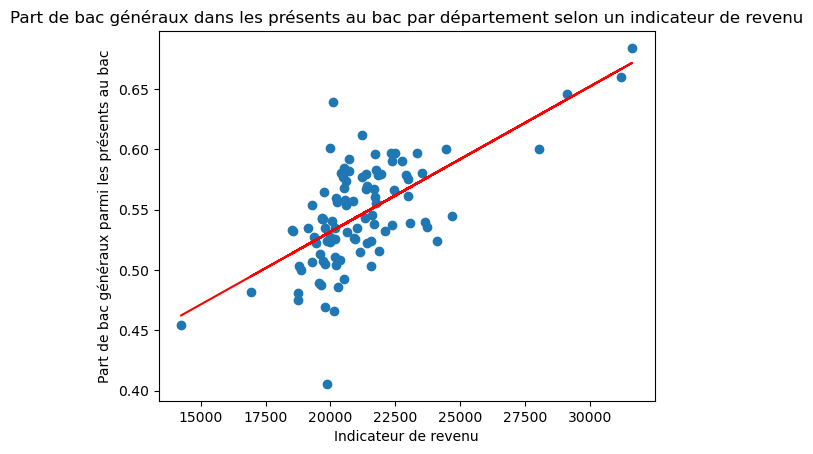

In [70]:
x = np.array(df_reg[["moyenne_mediane_toutes_communes"]])
y = np.array(df_reg[["Part général dans présence au bac"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)

plt.scatter(x, y)
plt.plot(x, y_predicted, color='r')
plt.title ("Part de bac généraux dans les présents au bac par département selon un indicateur de revenu")
plt.xlabel ("Indicateur de revenu")
plt.ylabel ("Part de bac généraux parmi les présents au bac")

r2 = r2_score (y, y_predicted)
print("R² = ", r2)

La corrélation entre le revenu "médian/moyen" du département et la part de bacheliers généraux parmi ceux présents au bac est importante. En d'autres termes, un département plus riche présente en moyenne plus de jeunes au baccalauréat général. Du plus, on obtient un R² de 0.43 ce qui est élevé donc le pouvoir explicatif de cet indicateur du revenu est important.  


Cela confirme donc notre hypothèse d'une sélection sociale basée sur le revenu dans le choix de la filière du baccalauréat : les personnes riches encouragent davantage leurs enfants à suivre un bac général. 

## Conclusion et discussion

Pour conclure, ce projet nous a permis de montrer qu’il existe une corrélation entre revenu médian des communes et taux de réussite au baccalauréat mais surtout entre revenu médian et répartition des filières du baccalauréat. Ainsi, plus un lycéen habite dans une commune riche, plus il est probable qu’il se présente à un baccalauréat général et plus il est probable qu’il obtienne le baccalauréat.

Néamoins, notre travail présente de nombreuses limites. Tout d'abord, nos indicateurs sont discutables. Par exemple, le revenu médian ne tient pas compte des valeurs extrêmes. De plus, il ne tient pas compte des inégalités au sein d'une ville. Ainsi, il ne nous pas été possible de mettre en évidence les inégalités au sein d'une même ville, notamment celles qui ont plusieurs lycées. Par exemple, la ville de Grenoble est partitionnée entre des quartiers aisés et quartiers plus populaires mais cette distinction n'a pas pu être mise en évidence. Surtout, on a déterminé le revenu par rapport aux revenus d'où se trouvent les lycées et non pas les communes de leurs secteurs associés à la carte scolaire. En effet, nous n'avions pas accès à la carte scolaire des lycées ni au revenu par secteurs. Malgré tout, les secteurs de la carte scolaire sont peu pertinents pour appréhender la filière professionnelle. 

Par ailleurs, il aurait été intéressant d'aborder le revenu comme un facteur pouvant influencer la réussite au baccalauréat au milieu d'autres (position sociale des parents, nombre d'élèves par classe...). Cela nous aurait permis de conclure sur l'importance du revenu pour expliquer la réussite et donc d'établir ou non un lien de causalité. 

Bien que ce projet n’ait pas la portée explicative que nous aurions souhaité, il a été très enrichissant pour appréhender la manipulation, la visualisation et la modélisation de données en Python mais surtout leur application à des cas concrets et utiles. Même si cela a été parfois frustrant, l’utilisation de Git nous a aussi permis d’acquérir des compétences qui nous resserviront dans le futur.



## Annexe - Tentative de pallier les limites de nos modèles

Nous avons tenté de créer un modèle qui simule une pseudo-carte scolaire pour tenir compte du revenu dans les communes proches.

Voici notre simulation. En effet, notre modélisation du lien entre taux de réussite au baccalauréat et revenu souffre probablement du fait qu'on ait associé le revenu des élèves à celui des communes de leur lycée. Or, des élèves viennent d'autres communes non pourvues d'établissement scolaire et le revenu médian peut être très hétérogène entre deux communes. On va donc essayer de refaire une carte scolaire de la manière suivante :

Chaque commune sera associée à un point géographique. Si elle est dépourvue de lycée, on l'associera au lycée le plus proche.
- On pondérera alors un revenu médian pour chaque lycée en fonction du revenu médian de chaque commune qui lui est associée et de la population des communes prises en compte. On posera donc l'hypothèse que la proportion de bacheliers potentiels est identique dans chaque commune (ce qui est discutable étant donné qu'il y'a une ségrégation spatiale générationnelle sur le territoire français)
- On procédera ainsi à une nouvelle régression avec les données obtenues

On doit donc créer une base de données adaptée. Il faut qu'on ait dedans

- Chaque établissement scolaire, avec son nombre de candidats et le taux de réussite par filières.
- Chaque commune avec le revenu médian associé
- Les coordonnées géographiques des lycées et des communes En plus des bases de données utilisées précédemment, nous avons utilisé une base de données de La Poste pour avoir la longitude et la latitude de chaque commune.

### A - Traitement de données pour le modèle

On va chercher à créer une base de données regroupant :
- L'ensemble des communes française, leur population et leur revenu médian 
- Les établissements scolaires avec leur taux de réussite dans chaque filière
- La situation géographique des villes et des lycées

Pour ce faire, nous utiliserons les bases précédemment mises en oeuvre dans la partie Manipulation afin d'avoir accès à la plupart de ces informations. Etant donné que la population n'était pas renseignée ainsi que la situation géographique de chaque commune, nous avons ajouté quelques bases de données pour obtenir ces bases de données supplémentaire

Pour importer les nouvelles données brutes si nécessaire (à des fins de reproductibilité si les url ne fonctionnent plus...)

In [71]:
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/coordonnees_communes.csv 
#!wget https://minio.lab.sspcloud.fr/rsalaun/projet_python/population.xlsx

In [72]:
#Importations des bases de données et début de nettoyage

#Base de communes
df_communes = pd.read_excel("FILO2019_DEC_COM.xlsx", sheet_name = 1, header=[4,5])
df_com = df_communes.copy()
df_com = df_com.drop(['PMIMP19', 'Q119', 'Q319','Q3_Q1','D119', 'D219', 'D319', 'D419', 'D619', 'D719', 'D819', 'D919', 'RD', 'S80S2019', 'GI19', 'PACT19', 'PTSA19', 'PCHO19', 'PBEN19', 'PPEN19', 'PAUT19'], axis = 1, level = 1 )

#Base des lycées
dflyc = pd.read_excel('base_def_SansDOMTOM.xlsx')
dflyc = dflyc[dflyc['Code_commune'].str.startswith('2B')==False] #On exclut la Corse pour faciliter des conversions de chaînes de caractère en nombre entier pour des jointures futures
dflyc = dflyc[dflyc['Code_commune'].str.startswith('2A')==False]

#Base des coordonnées géographiques des communes 
dfgeo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/dbe8a621-a9c4-4bc3-9cae-be1699c5ff25')

#Base population
dfpop = pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/4989724/ensemble.xlsx", sheet_name=4, header=7)
dfpop =dfpop[["Code département", "Code commune", "Population totale"]]
dfpop = dfpop[dfpop['Code département'].str.startswith('2B')==False] #On exclut la Corse
dfpop = dfpop[dfpop['Code département'].str.startswith('2A')==False]
dfpop["Code département"] = dfpop["Code département"].astype(int)
for i in range(dfpop.shape[0]):
    dfpop.loc[dfpop.index[i], "Code département"] = dfpop.loc[dfpop.index[i], "Code département"]*1000 #On recrée les codes communes en les liant aux codes départementaux pour uniformiser avec les codes communes des autres bases afin que nos jointures fonctionnent
dfpop['Code Commune INSEE'] = dfpop['Code département'] + dfpop['Code commune'] #Les codes communes seront alors compatibles avec ceux de la base de données des communes
dfpop = dfpop.drop(["Code département", "Code commune"], axis=1)

In [73]:
# Nettoyage de la base dfgeo
dfgeo=dfgeo[dfgeo['code_postal']<97000]
dfgeo = dfgeo.drop(["code_postal", "libelle_acheminement", "ligne_5", "nom_commune_complet", "nom_departement", "nom_region","article"], axis=1)
dfgeo

#Nettoyagede la base dflyc
dflyc.columns
dflyc = dflyc.drop(["Unnamed: 0", "Valeur ajoutée du taux de réussite_GNLE", "Valeur ajoutée du taux de réussite_Valeur ajoutée techno", "Nombre d'élèves présents au Bac_TOTAL_LGT","Taux de réussite bruts_TOTAL_LGT", "Valeur ajoutée du taux de réussite_TOTAL_LGT", "Valeur ajoutée du taux de réussite_TOTAL_Pro", "Nbre de ménages fiscaux_NBMEN19","Nbre de personnes dans les ménages fiscaux_NBPERS19", "Nbre d'unités de consommation dans les ménages fiscaux_NBUC19", "coordonnee_X", "coordonnee_Y", "epsg"], axis=1)
dflyc

#Amélioration de la base concernant les communes françaises
df_com.columns = df_com.columns.map('_'.join).str.strip('_')
df_com = df_com.drop(["Nbre de ménages fiscaux_NBMEN19","Nbre de personnes dans les ménages fiscaux_NBPERS19","Nbre d'unités de consommation dans les ménages fiscaux_NBUC19"], axis=1)
df_com = df_com[df_com["Code géographique_CODGEO"].str.startswith('2A')==False]
df_com = df_com[df_com["Code géographique_CODGEO"].str.startswith('2B')==False] #On enlève la Corse pour faciliter des manipulations futures
df_com["Code géographique_CODGEO"] = df_com["Code géographique_CODGEO"].astype(int) #Pour la jointure, on a besoin que CODGEO soit un entier
df_com2 = df_com.merge(dfpop, how='left', left_on = "Code géographique_CODGEO", right_on='Code Commune INSEE')
df_com2["Code géographique_CODGEO"] = df_com2["Code géographique_CODGEO"].astype(str) #Pour les jointures futures, on a besoin de chaines de carractères

In [74]:
#Définition d'une distance en fonction de la dataframe
def distance(IDlycee, IDcommune, df):
    i = df.Identifiant_de_l_etablissement[df.Identifiant_de_l_etablissement==IDlycee].index.tolist()[0]
    j = dfcomsanslyc.code_commune_INSEE[dfcomsanslyc.code_commune_INSEE==IDcommune].index.tolist()[0]
    longcom = dfcomsanslyc.loc[dfcomsanslyc.index[j], 'longitude_y']
    latcom = dfcomsanslyc.loc[dfcomsanslyc.index[j], 'latitude_y']
    longlyc =df.loc[df.index[i], 'longitude_y']
    latlyc =df.loc[dfaveclyc.index[i], 'longitude_y']
    d = np.sqrt((longcom - longlyc)**2 + (latcom- latlyc)**2 )
    return d

In [75]:
#Fusion des bases

#Fusion population/lycée
dflyc['Code_commune'] = dflyc['Code_commune'].astype(int) #On adapte les types pour faciliter les jointures
dflyc = dflyc.merge(dfpop, left_on = 'Code_commune', right_on='Code Commune INSEE')
dflyc['Code_commune'] = dflyc['Code_commune'].astype(str)

#Fusion commune/géographie
dfcomgeo  = df_com2.merge(dfgeo, how= 'left', left_on='Code géographique_CODGEO', right_on = 'code_commune_INSEE')
dfcomgeo = dfcomgeo.drop(["nom_commune_postal", "nom_commune"], axis=1)

#Fusion commune, lycée 
dfmodel = pd.merge(dflyc, dfcomgeo, how = 'outer', left_on = "Code_commune", right_on ='code_commune_INSEE')
dfmodel

,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Code_commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Nombre d'élèves présents au Bac_Somme Techno,...,Libellé géographique_LIBGEO,Médiane (€)_Q219_y,Population totale_y,Code Commune INSEE_y,code_commune_INSEE,latitude_y,longitude_y,code_commune,code_departement,code_region
0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,4019,PU,54.0,98.0,NaN,...,Barcelonnette,19070,2773.0,4019.0,4019,44.378561,6.652151,19.0,4,93.0
1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,4019,PU,NaN,NaN,NaN,...,Barcelonnette,19070,2773.0,4019.0,4019,44.378561,6.652151,19.0,4,93.0
2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,4070,PU,122.0,99.0,78.0,...,Digne-les-Bains,19840,17240.0,4070.0,4070,44.090872,6.235903,70.0,4,93.0
3,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,4070,PU,122.0,99.0,78.0,...,Digne-les-Bains,19840,17240.0,4070.0,4070,44.090872,6.235903,70.0,4,93.0
4,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,4070,PU,98.0,100.0,67.0,...,Digne-les-Bains,19840,17240.0,4070.0,4070,44.090872,6.235903,70.0,4,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Villeron,24910,1265.0,95675.0,95675,49.060843,2.534511,675.0,95,11.0
38872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Villers-en-Arthies,27360,507.0,95676.0,95676,49.085900,1.730396,676.0,95,11.0
38873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Villiers-Adam,33010,872.0,95678.0,95678,49.070289,2.239509,678.0,95,11.0
38874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Villiers-le-Sec,25690,190.0,95682.0,95682,49.074309,2.386890,682.0,95,11.0


Etant donné le nombre de colonnes que l'on a obtenu, on va chercher à limiter les doublons en regroupant certaines données dans des colonnes similaires. Pour les lycées, leur situation géographique sera alors associée à celle de leur commune mais on pose l'hypothèse que cela ne nuira pas considérablement à notre modèle, la carte scolaire étant assez aléatoirement respectée dans les grandes villes en raison de la diversité des filières et de stratégies familiales.

In [76]:
dfmodelc = dfmodel.copy()

dfmodelc["Informations établissement_Ville"]= dfmodelc["Informations établissement_Ville"].fillna(0)
dfmodelcnz = dfmodelc[dfmodelc["Informations établissement_Ville"]!=0] #Les communes ayant un lycée
dfmodelcz = dfmodelc[dfmodelc["Informations établissement_Ville"]==0] #Les communes n'ayant pas de lycée
'''Pour les communes qui ont un lycée, on veut que leurs informations soient dans la même colonne que celle 
pour les communes n'ayant pas de lycée et limiter les doublons liés aux jointures, même si ça implique de simplifier
les coordonnées géographique des lycées par ceux de leurs communes.'''
for i in range(dfmodelcnz.shape[0]):
    dfmodelcnz.loc[dfmodelcnz.index[i], "Libellé géographique_LIBGEO"]=dfmodelcnz.loc[dfmodelcnz.index[i],"Informations établissement_Ville"]
    dfmodelcnz.loc[dfmodelcnz.index[i], "code_commune_INSEE"]=dfmodelcnz.loc[dfmodelcnz.index[i],"Code_commune"]
    dfmodelcnz.loc[dfmodelcnz.index[i], "Médiane (€)_Q219_y"]=dfmodelcnz.loc[dfmodelcnz.index[i],"Médiane (€)_Q219_x"]
    dfmodelcnz.loc[dfmodelcnz.index[i], "latitude_y"]=dfmodelcnz.loc[dfmodelcnz.index[i],"latitude_x"]
    dfmodelcnz.loc[dfmodelcnz.index[i], "longitude_y"]=dfmodelcnz.loc[dfmodelcnz.index[i],"longitude_x"]
dfmodelc = pd.concat([dfmodelcnz, dfmodelcz])

#On ne garde que les colonnes qui nous intéressent
dfmodelc = dfmodelc.drop(["Code_commune","Informations établissement_Ville","code_commune", "latitude_x", "longitude_x", "Médiane (€)_Q219_x", "Code géographique_CODGEO", "Code Commune INSEE_x", 'Population totale_x', 'Code Commune INSEE_y'], axis=1)
dfmodelc = dfmodelc.drop_duplicates() #On supprime les doublons
dfmodelc = dfmodelc.reset_index() #On reset les index
dfmodelc

,index,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Nombre d'élèves présents au Bac_Somme Techno,Taux de réussite bruts_Taux brut techno,...,Taux de réussite bruts_TOTAL_Pro,Indice de Gini_GI19,Libellé géographique_LIBGEO,Médiane (€)_Q219_y,Population totale_y,code_commune_INSEE,latitude_y,longitude_y,code_departement,code_region
0,0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),PU,54.0,98.0,NaN,NaN,...,NaN,0.328,BARCELONNETTE,19070,2773.0,4019,44.388778,6.651860,4,93.0
1,1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),PU,NaN,NaN,NaN,NaN,...,87.0,0.328,BARCELONNETTE,19070,2773.0,4019,44.388778,6.651860,4,93.0
2,2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,PU,122.0,99.0,78.0,93.435897,...,NaN,0.362,DIGNE LES BAINS,19840,17240.0,4070,44.100803,6.234041,4,93.0
3,4,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,PU,98.0,100.0,67.0,98.447761,...,NaN,0.362,DIGNE LES BAINS,19840,17240.0,4070,44.073766,6.181939,4,93.0
4,6,0040007L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PROFESSIONNEL BEAU DE ROCHAS,PU,NaN,NaN,NaN,NaN,...,87.0,0.362,DIGNE LES BAINS,19840,17240.0,4070,44.100068,6.234224,4,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33721,38871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Villeron,24910,1265.0,95675,49.060843,2.534511,95,11.0
33722,38872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Villers-en-Arthies,27360,507.0,95676,49.085900,1.730396,95,11.0
33723,38873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Villiers-Adam,33010,872.0,95678,49.070289,2.239509,95,11.0
33724,38874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Villiers-le-Sec,25690,190.0,95682,49.074309,2.386890,95,11.0


### B - Le modèle

On va essayer de déterminer, pour chaque commune dépourvue de lycée, le lycée qui est le plus proche géographiquement. Ainsi, pour chaque lycée, on va grouper en son sein des communes associées. 
On posera l'hypothèse que tous les élèves vont nécessairement être scolarisés dans un lycée de leur département pour alléger l'algorithme.

In [77]:
#On prépare quelques éléments pour faciliter la modélisation
#On distingue la base de données des lycées de la base de données des communes dépourvues de lycée
dfmodelc['Informations établissement_Académie'] = dfmodelc['Informations établissement_Académie'].fillna(0)
dfcomsanslyc = dfmodelc[dfmodelc['Informations établissement_Académie']==0] #La base de données des communes dépourvues de lycée
dfaveclyc = dfmodelc[dfmodelc['Informations établissement_Académie']!=0] #La base de données des lycées 

On construit une fonction de distance à partir de la latitude et de la longitude pour déterminer les proximités géographiques entre communes et lycées.

In [78]:
#Définition d'une distance en fonction de la dataframe
def distance(IDlycee, IDcommune, df):
    i = df.Identifiant_de_l_etablissement[df.Identifiant_de_l_etablissement==IDlycee].index.tolist()[0]
    j = dfcomsanslyc.code_commune_INSEE[dfcomsanslyc.code_commune_INSEE==IDcommune].index.tolist()[0]
    longcom = dfcomsanslyc.loc[dfcomsanslyc.index[j], 'longitude_y']
    latcom = dfcomsanslyc.loc[dfcomsanslyc.index[j], 'latitude_y']
    longlyc =df.loc[df.index[i], 'longitude_y']
    latlyc =df.loc[dfaveclyc.index[i], 'longitude_y']
    d = np.sqrt((longcom - longlyc)**2 + (latcom- latlyc)**2 )
    return d

On va pour chaque établissement créer une liste vide qui contiendra les communes affectées à cet établissement. Elles seront regroupées sous la forme d'un dictionnaire. Dans chaque liste se trouveront les communes dépourvues de lycée ainsi que les communes dans lesquelles se trouve le lycée. On distingue les lycées professionnels des autres lycées parce que le choix de filière n'est pas déterminé par la situation géographique (un élève n'ira pas au lycée professionnel parce que ce lycée est plus proche de son domicile).

In [79]:
#Création des listes pour chaque lycée comportant la commune où il se trouve

#On distingue les lycées généraux/technologiques des lycées professionnels
dfgt = dfaveclyc.copy()
dfgt = dfgt.fillna(0)
dfgt = dfgt[dfgt["Nombre d'élèves présents au Bac_TOTAL_Pro"]==0]
dfgt = dfgt.reset_index()

dfp = dfgt = dfaveclyc.copy()
dfp = dfp.fillna(0)
dfp = dfp[dfp["Nombre d'élèves présents au Bac_TOTAL_Pro"]!=0]
dfp = dfp.reset_index()

#Général et technologique
lyceesgt = {} 
for i in range(dfgt.shape[0]):
    lyceesgt[dfgt.loc[dfgt.index[i], 'Identifiant_de_l_etablissement']] = [dfgt.loc[dfgt.index[i], "code_commune_INSEE"]]
    
    
#Professionnel
lyceesp = {}
for i in range(dfp.shape[0]):
    lyceesp[dfp.loc[dfp.index[i], 'Identifiant_de_l_etablissement']] = [dfp.loc[dfp.index[i], "code_commune_INSEE"]]

Avec cette boucle, nous chercherons à associer à chaque établissement ses communes. Ce code ne marche pas en raison de range de liste mal géré, nous le laissons pour montrer l'idée en commentaire.

In [80]:
#On remplit les listes 

'''for df in [dfgt, dfp]: #On différencie les lycées généraux et technologiques des lycées professionnels
    if df.shape == dfgt.shape: #Pour différencier, les 2 sont de dimensions différentes et cela rend le booléen moins ambigu
        lyc = lyceesgt
    else:
        lyc = lyceesp
    for j in range(dfcomsanslyc.shape[0]): #Pour toutes les communes
        indcom = df.loc[df.index[j], 'code_commune_INSEE']
        a = 0
        b = 10000000000000000
        for k in range(df.shape[0]):
            if df.loc[df.index[j], 'code_departement'] == df.loc[df.index[k], 'code_departement']: #On allège en ce restreignant au département
                indlyc = str(df.loc[df.index[k], 'Identifiant_de_l_etablissement'])
                print(indlyc)
                a = distance(indcom,indlyc,df) #On calcule la distance en fonction de la commune, du lycée et de la base de données sollicitée
                if (b<a): #On remplace la valeur que l'on garde si la distance calculée est plus courte que la précédente
                    b = a
                    IDlyc = df.loc[df.index[k], 'Identifiant_de_l_etablissement']
        lyc[str(IDlyc)].append(indcom)'''

"for df in [dfgt, dfp]: #On différencie les lycées généraux et technologiques des lycées professionnels\n    if df.shape == dfgt.shape: #Pour différencier, les 2 sont de dimensions différentes et cela rend le booléen moins ambigu\n        lyc = lyceesgt\n    else:\n        lyc = lyceesp\n    for j in range(dfcomsanslyc.shape[0]): #Pour toutes les communes\n        indcom = df.loc[df.index[j], 'code_commune_INSEE']\n        a = 0\n        b = 10000000000000000\n        for k in range(df.shape[0]):\n            if df.loc[df.index[j], 'code_departement'] == df.loc[df.index[k], 'code_departement']: #On allège en ce restreignant au département\n                indlyc = str(df.loc[df.index[k], 'Identifiant_de_l_etablissement'])\n                print(indlyc)\n                a = distance(indcom,indlyc,df) #On calcule la distance en fonction de la commune, du lycée et de la base de données sollicitée\n                if (b<a): #On remplace la valeur que l'on garde si la distance calculée est 

On va chercher à estimer un revenu pour chaque lycée à partir des communes qui lui sont associées en pondérant par les effectifs de population des-dites communes. Ce code ne fonctionne pas car nous n'avons pas eu le temps de déterminer totalement l'algorithme mais nous exposons tout de même l'idée. Notre nouvelle variable devait s'appeler Revenu Local

In [81]:
'''dfaveclycc=dfaveclyc.copy()

revenu_nouveau =[]
for i in range(dfaveclycc.shape[0]):
    revenu_nouveau.append(0) 
dfaveclycc['Revenu Local'] = revenu_nouveau


for elem in lycees:
    revenu_nouveau = pop*revenu de chaque com / somme des pops
    dfaveclycc.loc['indice', 'Revenu Local']=revenu_nouveau

#On joint le revenu nouveau à l'ancienne base de données en créant une nouvelle colonne. '''

"dfaveclycc=dfaveclyc.copy()\n\nrevenu_nouveau =[]\nfor i in range(dfaveclycc.shape[0]):\n    revenu_nouveau.append(0) \ndfaveclycc['Revenu Local'] = revenu_nouveau\n\n\nfor elem in lycees:\n    revenu_nouveau = pop*revenu de chaque com / somme des pops\n    dfaveclycc.loc['indice', 'Revenu Local']=revenu_nouveau\n\n#On joint le revenu nouveau à l'ancienne base de données en créant une nouvelle colonne. "

L'idée était donc effectuer à nouveau les régressions faites précédemment mais en tenant compte du revenu local, c'est-à-dire un revenu médian pondéré par les communes alentours aux lycées quand celles-ci sont dépourvues d'établissement scolaire. On recouvre ainsi davantage la réalité économique des bacheliers potentiels. Nous avons repris les codes de régression précédents mais ils ne sont pas utilisables car nous ne sommes pas parvenus à créer les bases recherchées. Nous ne pourrons donc pas livrer d'interprétation. Nous avons distingué par filières. Nous aurions alors comparé les R² pour déterminer si ce modèle apportait davantage de précision pour répondre à notre problématique.

In [82]:
'''#Régression pour la filière générale
df_reg_GL = dfgt[[ "Revenu Local", "Taux de réussite bruts_GNLE"]]
df_reg_GL = df_reg_GL.dropna(axis = 0, how = "any")
df_reg_GL

x = np.array(df_reg_GL[["Revenu Local"]])
y = np.array(df_reg_GL[["Taux de réussite bruts_GNLE"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat général en fonction du revenu médian")
plt.xlabel ("Revenu médian local")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)
'''



'#Régression pour la filière générale\ndf_reg_GL = dfgt[[ "Revenu Local", "Taux de réussite bruts_GNLE"]]\ndf_reg_GL = df_reg_GL.dropna(axis = 0, how = "any")\ndf_reg_GL\n\nx = np.array(df_reg_GL[["Revenu Local"]])\ny = np.array(df_reg_GL[["Taux de réussite bruts_GNLE"]])\n\nx = x.reshape(-1,1)\ny = y.reshape(-1,1)\n\nregression_model = LinearRegression()\nregression_model.fit(x,y)\ny_predicted = regression_model.predict(x)\n\n\nplt.scatter(x,y, s=1)\nplt.plot(x, y_predicted, color=\'r\')\nplt.title ("Taux de réussite au baccalauréat général en fonction du revenu médian")\nplt.xlabel ("Revenu médian local")\nplt.ylabel ("Taux de réussite")\nplt.show()\n\nr2 = r2_score (x, y)\nprint("R² = ", r2)\n'

In [83]:
'''#Régression pour la filière technologique
df_reg_TL = dfgt[[ "Revenu Local", "Taux de réussite bruts_Taux brut techno"]]
df_reg_TL = df_reg_GL.dropna(axis = 0, how = "any")
df_reg_TL

x = np.array(df_reg_TL[["Revenu Local"]])
y = np.array(df_reg_TL[["Taux de réussite bruts_Taux brut techno"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat général en fonction du revenu médian")
plt.xlabel ("Revenu médian local")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)'''

'#Régression pour la filière technologique\ndf_reg_TL = dfgt[[ "Revenu Local", "Taux de réussite bruts_Taux brut techno"]]\ndf_reg_TL = df_reg_GL.dropna(axis = 0, how = "any")\ndf_reg_TL\n\nx = np.array(df_reg_TL[["Revenu Local"]])\ny = np.array(df_reg_TL[["Taux de réussite bruts_Taux brut techno"]])\n\nx = x.reshape(-1,1)\ny = y.reshape(-1,1)\n\nregression_model = LinearRegression()\nregression_model.fit(x,y)\ny_predicted = regression_model.predict(x)\n\n\nplt.scatter(x,y, s=1)\nplt.plot(x, y_predicted, color=\'r\')\nplt.title ("Taux de réussite au baccalauréat général en fonction du revenu médian")\nplt.xlabel ("Revenu médian local")\nplt.ylabel ("Taux de réussite")\nplt.show()\n\nr2 = r2_score (x, y)\nprint("R² = ", r2)'

In [84]:
'''#Régression pour la filière professionnelle
df_reg_GL = dfp[[ "Revenu Local", "Taux de réussite bruts_GNLE"]]
df_reg_GL = df_reg_GL.dropna(axis = 0, how = "any")
df_reg_GL

x = np.array(df_reg_techno[["Revenu Local"]])
y = np.array(df_reg_techno[["Taux de réussite bruts_GNLE"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.title ("Taux de réussite au baccalauréat général en fonction du revenu médian")
plt.xlabel ("Revenu médian local")
plt.ylabel ("Taux de réussite")
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)'''

'#Régression pour la filière professionnelle\ndf_reg_GL = dfp[[ "Revenu Local", "Taux de réussite bruts_GNLE"]]\ndf_reg_GL = df_reg_GL.dropna(axis = 0, how = "any")\ndf_reg_GL\n\nx = np.array(df_reg_techno[["Revenu Local"]])\ny = np.array(df_reg_techno[["Taux de réussite bruts_GNLE"]])\n\nx = x.reshape(-1,1)\ny = y.reshape(-1,1)\n\nregression_model = LinearRegression()\nregression_model.fit(x,y)\ny_predicted = regression_model.predict(x)\n\n\nplt.scatter(x,y, s=1)\nplt.plot(x, y_predicted, color=\'r\')\nplt.title ("Taux de réussite au baccalauréat général en fonction du revenu médian")\nplt.xlabel ("Revenu médian local")\nplt.ylabel ("Taux de réussite")\nplt.show()\n\nr2 = r2_score (x, y)\nprint("R² = ", r2)'